recon, mu, logvar = vae(input)

In [1]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from torch.utils.data import DataLoader
from gan_synthesis.datasets.dataset import Dataset
from torch import unique
dataset = Dataset()
loader = DataLoader(dataset, batch_size=369)

classes = 0
frequencies = {0: 0, 1: 0, 2: 0, 3: 0}
for _, seg in loader:
    uniques, counts = unique(seg, return_counts=True)
    print(counts)

weights = 1 / counts + 4e-6
class_weights = weights / weights.sum()

percents = counts / counts.sum()
print(percents)

tensor([2458239,  246423,  486903,  209139])
tensor([0.7229, 0.0725, 0.1432, 0.0615])


In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from gan_synthesis.mask_vae_models.vae import VAE, dice_loss_mc_opts, kl_divergence_capacity, kl_divergence
from gan_synthesis.datasets.dataset import Dataset
from tqdm import tqdm

# Instantiate data loaders
dataset = Dataset()
train_set, test_set = dataset.split(0.95)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

# Instantiate models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(size=96, latent_dim=16).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=dataset.weights.to(device))

# Before the loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
ce_losses = []

# final_z = torch.zeros(shape=)
num_epochs = 600
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_kld_loss = 0.0
    running_ce_loss = 0.0
    running_dice_loss = 0.0

    # if epoch == 499:
    #     with torch.no_grad():
    #         recon, mu, logvar = model(seg_input)


    # if epoch % 10 == 0 and epoch != 0:
    #     with torch.no_grad:
    #         recon, mu, logvar = model

    for _, seg in tqdm(train_loader, desc="Training", leave=False):
        correct, total = 0, 0
        seg_input = seg.to(torch.float32).to(device)
        seg_target = seg.squeeze(1).long().to(device)

        recon, mu, logvar = model(seg_input)
        # if epoch == 499:
        #     with torch.no_grad():
        # kld = kl_divergence(mu, logvar)
        # print(kld, kld.shape)
        kld_loss = kl_divergence_capacity(mu, logvar, epoch=epoch, beta=1, max_capacity=50)
        ce_loss = criterion(recon, seg_target)
        dice_loss = dice_loss_mc_opts(recon, seg_target, ignore_bg=True)
        loss = ce_loss + kld_loss + 0.5 * dice_loss

        pred = torch.argmax(recon, dim=1)
        correct += (pred == seg_target).sum().item()
        total += seg.numel()

        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        running_kld_loss += kld_loss
        running_ce_loss += ce_loss
        running_dice_loss += dice_loss
        running_train_loss += loss.item()
    
    

    avg_train_loss = running_train_loss / len(train_loader)
    avg_kld_loss = running_kld_loss / len(train_loader)
    avg_ce_loss = running_ce_loss / len(train_loader)
    avg_dice_loss = running_dice_loss / len(train_loader)
    ce_losses.append(avg_ce_loss.item())
    train_losses.append(avg_train_loss)

    acc = correct / total
    train_accuracies.append(acc)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for _, seg in tqdm(test_loader, desc="Test", leave=False):
            seg_input = seg.to(torch.float32).to(device)
            seg_target = seg.squeeze(1).long().to(device)
            recon, mu, logvar = model(seg_input)
            kld_loss = kl_divergence_capacity(mu, logvar, epoch=epoch, beta=1, max_capacity=50)
            ce_loss = criterion(recon, seg_target)
            dice_loss = dice_loss_mc_opts(recon, seg_target, ignore_bg=True)
            loss = ce_loss + 0.5 * dice_loss + kld_loss
            running_val_loss += loss.item()

            pred = torch.argmax(recon, dim=1)
            correct += (pred == seg_target).sum().item()
            total += seg.numel()

    avg_val_loss = running_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    acc = correct / total
    val_accuracies.append(acc)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, KLD Train Loss: {avg_kld_loss:.4f}, CE Train Loss: {avg_ce_loss:.4f}, Dice Train Loss: {avg_dice_loss:.4f}\
            \nVal Loss: {avg_val_loss:.4f}, Val Acc: {acc:.4f}")


[Epoch 1] Train Loss: 2.3461, KLD Train Loss: 0.6743, CE Train Loss: 1.2374, Dice Train Loss: 0.8687            
Val Loss: 1.4739, Val Acc: 0.7283


[Epoch 2] Train Loss: 1.6791, KLD Train Loss: 0.2572, CE Train Loss: 1.0016, Dice Train Loss: 0.8406            
Val Loss: 1.5004, Val Acc: 0.7126


[Epoch 3] Train Loss: 1.5163, KLD Train Loss: 0.1647, CE Train Loss: 0.9366, Dice Train Loss: 0.8299            
Val Loss: 1.3553, Val Acc: 0.7244


[Epoch 4] Train Loss: 1.5708, KLD Train Loss: 0.2714, CE Train Loss: 0.8886, Dice Train Loss: 0.8216            
Val Loss: 1.5770, Val Acc: 0.7331


[Epoch 5] Train Loss: 1.5314, KLD Train Loss: 0.2713, CE Train Loss: 0.8530, Dice Train Loss: 0.8141            
Val Loss: 1.5097, Val Acc: 0.7413


[Epoch 6] Train Loss: 1.3358, KLD Train Loss: 0.1029, CE Train Loss: 0.8290, Dice Train Loss: 0.8079            
Val Loss: 1.3624, Val Acc: 0.7486


[Epoch 7] Train Loss: 1.4533, KLD Train Loss: 0.2459, CE Train Loss: 0.8070, Dice Train Loss: 0.8007            
Val Loss: 1.5264, Val Acc: 0.7513


[Epoch 8] Train Loss: 1.4541, KLD Train Loss: 0.2622, CE Train Loss: 0.7938, Dice Train Loss: 0.7963            
Val Loss: 1.1736, Val Acc: 0.7532


[Epoch 9] Train Loss: 1.3977, KLD Train Loss: 0.2193, CE Train Loss: 0.7830, Dice Train Loss: 0.7908            
Val Loss: 1.2555, Val Acc: 0.7564


[Epoch 10] Train Loss: 1.4539, KLD Train Loss: 0.2873, CE Train Loss: 0.7733, Dice Train Loss: 0.7865            
Val Loss: 1.2188, Val Acc: 0.7533


[Epoch 11] Train Loss: 1.3645, KLD Train Loss: 0.2035, CE Train Loss: 0.7695, Dice Train Loss: 0.7830            
Val Loss: 1.4330, Val Acc: 0.7568


[Epoch 12] Train Loss: 1.4535, KLD Train Loss: 0.2989, CE Train Loss: 0.7644, Dice Train Loss: 0.7804            
Val Loss: 1.3732, Val Acc: 0.7605


[Epoch 13] Train Loss: 1.4056, KLD Train Loss: 0.2579, CE Train Loss: 0.7594, Dice Train Loss: 0.7766            
Val Loss: 1.2827, Val Acc: 0.7637


[Epoch 14] Train Loss: 1.6218, KLD Train Loss: 0.4791, CE Train Loss: 0.7556, Dice Train Loss: 0.7740            
Val Loss: 2.2481, Val Acc: 0.7648


[Epoch 15] Train Loss: 1.5972, KLD Train Loss: 0.4566, CE Train Loss: 0.7545, Dice Train Loss: 0.7723            
Val Loss: 1.7577, Val Acc: 0.7557


[Epoch 16] Train Loss: 1.4941, KLD Train Loss: 0.3589, CE Train Loss: 0.7502, Dice Train Loss: 0.7700            
Val Loss: 1.4643, Val Acc: 0.7603


[Epoch 17] Train Loss: 1.5583, KLD Train Loss: 0.4217, CE Train Loss: 0.7526, Dice Train Loss: 0.7681            
Val Loss: 1.5938, Val Acc: 0.7578


[Epoch 18] Train Loss: 1.7306, KLD Train Loss: 0.5950, CE Train Loss: 0.7515, Dice Train Loss: 0.7680            
Val Loss: 1.5853, Val Acc: 0.7675


[Epoch 19] Train Loss: 1.8378, KLD Train Loss: 0.7024, CE Train Loss: 0.7519, Dice Train Loss: 0.7670            
Val Loss: 1.5951, Val Acc: 0.7646


[Epoch 20] Train Loss: 1.9316, KLD Train Loss: 0.7998, CE Train Loss: 0.7488, Dice Train Loss: 0.7659            
Val Loss: 1.7060, Val Acc: 0.7578


[Epoch 21] Train Loss: 1.6612, KLD Train Loss: 0.5290, CE Train Loss: 0.7496, Dice Train Loss: 0.7650            
Val Loss: 1.8580, Val Acc: 0.7666


[Epoch 22] Train Loss: 1.5709, KLD Train Loss: 0.4410, CE Train Loss: 0.7481, Dice Train Loss: 0.7636            
Val Loss: 1.2635, Val Acc: 0.7589


[Epoch 23] Train Loss: 1.3188, KLD Train Loss: 0.1941, CE Train Loss: 0.7437, Dice Train Loss: 0.7620            
Val Loss: 1.4253, Val Acc: 0.7704


[Epoch 24] Train Loss: 1.4827, KLD Train Loss: 0.3604, CE Train Loss: 0.7413, Dice Train Loss: 0.7619            
Val Loss: 1.6402, Val Acc: 0.7530


[Epoch 25] Train Loss: 1.5537, KLD Train Loss: 0.4320, CE Train Loss: 0.7417, Dice Train Loss: 0.7601            
Val Loss: 1.7346, Val Acc: 0.7600


[Epoch 26] Train Loss: 1.7149, KLD Train Loss: 0.5993, CE Train Loss: 0.7363, Dice Train Loss: 0.7586            
Val Loss: 1.2026, Val Acc: 0.7679


[Epoch 27] Train Loss: 1.6396, KLD Train Loss: 0.5250, CE Train Loss: 0.7359, Dice Train Loss: 0.7572            
Val Loss: 1.3757, Val Acc: 0.7668


[Epoch 28] Train Loss: 1.6597, KLD Train Loss: 0.5488, CE Train Loss: 0.7322, Dice Train Loss: 0.7574            
Val Loss: 1.8709, Val Acc: 0.7650


[Epoch 29] Train Loss: 1.4520, KLD Train Loss: 0.3480, CE Train Loss: 0.7267, Dice Train Loss: 0.7546            
Val Loss: 1.0743, Val Acc: 0.7669


[Epoch 30] Train Loss: 1.5371, KLD Train Loss: 0.4441, CE Train Loss: 0.7172, Dice Train Loss: 0.7514            
Val Loss: 1.9015, Val Acc: 0.7712


[Epoch 31] Train Loss: 1.3430, KLD Train Loss: 0.2635, CE Train Loss: 0.7046, Dice Train Loss: 0.7499            
Val Loss: 1.0875, Val Acc: 0.7820


[Epoch 32] Train Loss: 1.3477, KLD Train Loss: 0.2729, CE Train Loss: 0.7008, Dice Train Loss: 0.7481            
Val Loss: 1.3335, Val Acc: 0.7761


[Epoch 33] Train Loss: 1.4236, KLD Train Loss: 0.3666, CE Train Loss: 0.6856, Dice Train Loss: 0.7428            
Val Loss: 1.3362, Val Acc: 0.7725


[Epoch 34] Train Loss: 1.3803, KLD Train Loss: 0.3188, CE Train Loss: 0.6908, Dice Train Loss: 0.7414            
Val Loss: 1.3868, Val Acc: 0.7716


[Epoch 35] Train Loss: 1.6522, KLD Train Loss: 0.5845, CE Train Loss: 0.6965, Dice Train Loss: 0.7423            
Val Loss: 1.7469, Val Acc: 0.7762


[Epoch 36] Train Loss: 1.6188, KLD Train Loss: 0.5498, CE Train Loss: 0.6979, Dice Train Loss: 0.7421            
Val Loss: 1.3834, Val Acc: 0.7849


[Epoch 37] Train Loss: 1.7453, KLD Train Loss: 0.6819, CE Train Loss: 0.6942, Dice Train Loss: 0.7383            
Val Loss: 1.5828, Val Acc: 0.7684


[Epoch 38] Train Loss: 1.5396, KLD Train Loss: 0.4891, CE Train Loss: 0.6829, Dice Train Loss: 0.7351            
Val Loss: 1.3134, Val Acc: 0.7848


[Epoch 39] Train Loss: 1.4646, KLD Train Loss: 0.4213, CE Train Loss: 0.6774, Dice Train Loss: 0.7318            
Val Loss: 1.4039, Val Acc: 0.7844


[Epoch 40] Train Loss: 1.7854, KLD Train Loss: 0.7468, CE Train Loss: 0.6728, Dice Train Loss: 0.7316            
Val Loss: 2.1240, Val Acc: 0.7861


[Epoch 41] Train Loss: 1.7184, KLD Train Loss: 0.6767, CE Train Loss: 0.6758, Dice Train Loss: 0.7319            
Val Loss: 1.6127, Val Acc: 0.7853


[Epoch 42] Train Loss: 1.6565, KLD Train Loss: 0.6276, CE Train Loss: 0.6660, Dice Train Loss: 0.7260            
Val Loss: 1.1495, Val Acc: 0.7964


[Epoch 43] Train Loss: 1.4847, KLD Train Loss: 0.4616, CE Train Loss: 0.6613, Dice Train Loss: 0.7236            
Val Loss: 1.7806, Val Acc: 0.7938


[Epoch 44] Train Loss: 1.2642, KLD Train Loss: 0.2468, CE Train Loss: 0.6559, Dice Train Loss: 0.7229            
Val Loss: 1.2592, Val Acc: 0.8004


[Epoch 45] Train Loss: 1.3585, KLD Train Loss: 0.3482, CE Train Loss: 0.6512, Dice Train Loss: 0.7184            
Val Loss: 1.0160, Val Acc: 0.8047


[Epoch 46] Train Loss: 1.2848, KLD Train Loss: 0.2775, CE Train Loss: 0.6481, Dice Train Loss: 0.7183            
Val Loss: 0.9753, Val Acc: 0.8031


[Epoch 47] Train Loss: 1.2994, KLD Train Loss: 0.2959, CE Train Loss: 0.6466, Dice Train Loss: 0.7138            
Val Loss: 1.2174, Val Acc: 0.7820


[Epoch 48] Train Loss: 1.4474, KLD Train Loss: 0.4371, CE Train Loss: 0.6540, Dice Train Loss: 0.7125            
Val Loss: 1.1557, Val Acc: 0.7869


[Epoch 49] Train Loss: 1.6427, KLD Train Loss: 0.6500, CE Train Loss: 0.6382, Dice Train Loss: 0.7090            
Val Loss: 1.7376, Val Acc: 0.7938


[Epoch 50] Train Loss: 1.4831, KLD Train Loss: 0.4943, CE Train Loss: 0.6342, Dice Train Loss: 0.7091            
Val Loss: 1.4329, Val Acc: 0.8069


[Epoch 51] Train Loss: 1.6402, KLD Train Loss: 0.6387, CE Train Loss: 0.6483, Dice Train Loss: 0.7064            
Val Loss: 0.9831, Val Acc: 0.7784


[Epoch 52] Train Loss: 1.6656, KLD Train Loss: 0.6691, CE Train Loss: 0.6422, Dice Train Loss: 0.7085            
Val Loss: 1.6655, Val Acc: 0.8020


[Epoch 53] Train Loss: 1.6994, KLD Train Loss: 0.7038, CE Train Loss: 0.6431, Dice Train Loss: 0.7050            
Val Loss: 0.9519, Val Acc: 0.7970


[Epoch 54] Train Loss: 1.8001, KLD Train Loss: 0.8147, CE Train Loss: 0.6346, Dice Train Loss: 0.7017            
Val Loss: 1.7112, Val Acc: 0.7974


[Epoch 55] Train Loss: 1.7135, KLD Train Loss: 0.7190, CE Train Loss: 0.6415, Dice Train Loss: 0.7058            
Val Loss: 1.6069, Val Acc: 0.8116


[Epoch 56] Train Loss: 1.7017, KLD Train Loss: 0.7001, CE Train Loss: 0.6505, Dice Train Loss: 0.7023            
Val Loss: 2.6130, Val Acc: 0.8067


[Epoch 57] Train Loss: 1.6156, KLD Train Loss: 0.5847, CE Train Loss: 0.6726, Dice Train Loss: 0.7165            
Val Loss: 1.1258, Val Acc: 0.8055


[Epoch 58] Train Loss: 1.5679, KLD Train Loss: 0.5619, CE Train Loss: 0.6490, Dice Train Loss: 0.7138            
Val Loss: 1.2139, Val Acc: 0.8025


[Epoch 59] Train Loss: 1.3179, KLD Train Loss: 0.3355, CE Train Loss: 0.6288, Dice Train Loss: 0.7073            
Val Loss: 1.3805, Val Acc: 0.8110


[Epoch 60] Train Loss: 1.2792, KLD Train Loss: 0.3028, CE Train Loss: 0.6283, Dice Train Loss: 0.6964            
Val Loss: 1.6463, Val Acc: 0.8048


[Epoch 61] Train Loss: 1.5712, KLD Train Loss: 0.5972, CE Train Loss: 0.6273, Dice Train Loss: 0.6932            
Val Loss: 1.2168, Val Acc: 0.8114


[Epoch 62] Train Loss: 1.9707, KLD Train Loss: 0.9971, CE Train Loss: 0.6250, Dice Train Loss: 0.6972            
Val Loss: 2.2917, Val Acc: 0.7951


[Epoch 63] Train Loss: 1.5093, KLD Train Loss: 0.5399, CE Train Loss: 0.6228, Dice Train Loss: 0.6931            
Val Loss: 1.2639, Val Acc: 0.8041


[Epoch 64] Train Loss: 1.3605, KLD Train Loss: 0.3957, CE Train Loss: 0.6239, Dice Train Loss: 0.6817            
Val Loss: 1.3373, Val Acc: 0.7942


[Epoch 65] Train Loss: 1.5508, KLD Train Loss: 0.5893, CE Train Loss: 0.6153, Dice Train Loss: 0.6924            
Val Loss: 2.2100, Val Acc: 0.8057


[Epoch 66] Train Loss: 1.6449, KLD Train Loss: 0.6801, CE Train Loss: 0.6190, Dice Train Loss: 0.6917            
Val Loss: 2.1762, Val Acc: 0.8145


[Epoch 67] Train Loss: 1.8513, KLD Train Loss: 0.8771, CE Train Loss: 0.6292, Dice Train Loss: 0.6900            
Val Loss: 1.1369, Val Acc: 0.8139


[Epoch 68] Train Loss: 1.3268, KLD Train Loss: 0.3674, CE Train Loss: 0.6156, Dice Train Loss: 0.6874            
Val Loss: 1.5896, Val Acc: 0.8102


[Epoch 69] Train Loss: 1.4272, KLD Train Loss: 0.4745, CE Train Loss: 0.6111, Dice Train Loss: 0.6833            
Val Loss: 1.2906, Val Acc: 0.8122


[Epoch 70] Train Loss: 1.3803, KLD Train Loss: 0.4356, CE Train Loss: 0.6019, Dice Train Loss: 0.6855            
Val Loss: 1.7629, Val Acc: 0.8140


[Epoch 71] Train Loss: 1.7638, KLD Train Loss: 0.8114, CE Train Loss: 0.6099, Dice Train Loss: 0.6851            
Val Loss: 1.5752, Val Acc: 0.7999


[Epoch 72] Train Loss: 1.4164, KLD Train Loss: 0.4611, CE Train Loss: 0.6113, Dice Train Loss: 0.6879            
Val Loss: 1.8258, Val Acc: 0.7881


[Epoch 73] Train Loss: 1.2983, KLD Train Loss: 0.3512, CE Train Loss: 0.6059, Dice Train Loss: 0.6824            
Val Loss: 1.9610, Val Acc: 0.8075


[Epoch 74] Train Loss: 1.8298, KLD Train Loss: 0.8950, CE Train Loss: 0.5957, Dice Train Loss: 0.6782            
Val Loss: 0.9548, Val Acc: 0.8066


[Epoch 75] Train Loss: 1.4363, KLD Train Loss: 0.4947, CE Train Loss: 0.6003, Dice Train Loss: 0.6827            
Val Loss: 1.7236, Val Acc: 0.8168


[Epoch 76] Train Loss: 2.0180, KLD Train Loss: 1.0833, CE Train Loss: 0.5969, Dice Train Loss: 0.6756            
Val Loss: 1.3665, Val Acc: 0.8118


[Epoch 77] Train Loss: 1.8266, KLD Train Loss: 0.8620, CE Train Loss: 0.6246, Dice Train Loss: 0.6800            
Val Loss: 2.5720, Val Acc: 0.8087


[Epoch 78] Train Loss: 5.7546, KLD Train Loss: 4.6963, CE Train Loss: 0.7025, Dice Train Loss: 0.7116            
Val Loss: 1.0843, Val Acc: 0.7959


[Epoch 79] Train Loss: 5.7652, KLD Train Loss: 4.6461, CE Train Loss: 0.7470, Dice Train Loss: 0.7442            
Val Loss: 3.0788, Val Acc: 0.7725


[Epoch 80] Train Loss: 4.9110, KLD Train Loss: 3.8502, CE Train Loss: 0.6946, Dice Train Loss: 0.7325            
Val Loss: 1.1030, Val Acc: 0.7998


[Epoch 81] Train Loss: 2.6340, KLD Train Loss: 1.6380, CE Train Loss: 0.6445, Dice Train Loss: 0.7032            
Val Loss: 1.6079, Val Acc: 0.7955


[Epoch 82] Train Loss: 1.8488, KLD Train Loss: 0.8796, CE Train Loss: 0.6195, Dice Train Loss: 0.6993            
Val Loss: 1.6318, Val Acc: 0.8036


[Epoch 83] Train Loss: 1.7167, KLD Train Loss: 0.7618, CE Train Loss: 0.6090, Dice Train Loss: 0.6917            
Val Loss: 2.6857, Val Acc: 0.8071


[Epoch 84] Train Loss: 2.1655, KLD Train Loss: 1.2209, CE Train Loss: 0.6034, Dice Train Loss: 0.6822            
Val Loss: 1.6338, Val Acc: 0.8154


[Epoch 85] Train Loss: 1.6195, KLD Train Loss: 0.6858, CE Train Loss: 0.5961, Dice Train Loss: 0.6752            
Val Loss: 2.4697, Val Acc: 0.8047


[Epoch 86] Train Loss: 2.1714, KLD Train Loss: 1.2287, CE Train Loss: 0.6034, Dice Train Loss: 0.6786            
Val Loss: 1.6262, Val Acc: 0.8090


[Epoch 87] Train Loss: 1.6942, KLD Train Loss: 0.7573, CE Train Loss: 0.6004, Dice Train Loss: 0.6731            
Val Loss: 1.1892, Val Acc: 0.8157


[Epoch 88] Train Loss: 1.5727, KLD Train Loss: 0.6368, CE Train Loss: 0.6001, Dice Train Loss: 0.6716            
Val Loss: 1.3752, Val Acc: 0.8146


[Epoch 89] Train Loss: 1.3405, KLD Train Loss: 0.4179, CE Train Loss: 0.5876, Dice Train Loss: 0.6698            
Val Loss: 1.0553, Val Acc: 0.8221


[Epoch 90] Train Loss: 1.6321, KLD Train Loss: 0.7101, CE Train Loss: 0.5877, Dice Train Loss: 0.6687            
Val Loss: 1.2989, Val Acc: 0.8056


[Epoch 91] Train Loss: 1.6084, KLD Train Loss: 0.6816, CE Train Loss: 0.5922, Dice Train Loss: 0.6692            
Val Loss: 1.0789, Val Acc: 0.8154


[Epoch 92] Train Loss: 1.7947, KLD Train Loss: 0.8760, CE Train Loss: 0.5863, Dice Train Loss: 0.6649            
Val Loss: 1.9982, Val Acc: 0.8034


[Epoch 93] Train Loss: 1.4931, KLD Train Loss: 0.5694, CE Train Loss: 0.5897, Dice Train Loss: 0.6680            
Val Loss: 1.0291, Val Acc: 0.8086


[Epoch 94] Train Loss: 1.4608, KLD Train Loss: 0.5432, CE Train Loss: 0.5858, Dice Train Loss: 0.6635            
Val Loss: 1.0026, Val Acc: 0.8167


[Epoch 95] Train Loss: 2.0176, KLD Train Loss: 1.0980, CE Train Loss: 0.5890, Dice Train Loss: 0.6612            
Val Loss: 2.4698, Val Acc: 0.8116


[Epoch 96] Train Loss: 2.3542, KLD Train Loss: 1.4393, CE Train Loss: 0.5832, Dice Train Loss: 0.6633            
Val Loss: 1.5360, Val Acc: 0.8137


[Epoch 97] Train Loss: 2.1580, KLD Train Loss: 1.2461, CE Train Loss: 0.5808, Dice Train Loss: 0.6622            
Val Loss: 2.8807, Val Acc: 0.8160


[Epoch 98] Train Loss: 2.5087, KLD Train Loss: 1.5928, CE Train Loss: 0.5864, Dice Train Loss: 0.6590            
Val Loss: 1.4591, Val Acc: 0.7978


[Epoch 99] Train Loss: 1.7685, KLD Train Loss: 0.8467, CE Train Loss: 0.5910, Dice Train Loss: 0.6617            
Val Loss: 1.1476, Val Acc: 0.8063


[Epoch 100] Train Loss: 2.4746, KLD Train Loss: 1.5579, CE Train Loss: 0.5872, Dice Train Loss: 0.6590            
Val Loss: 0.9303, Val Acc: 0.8058


[Epoch 101] Train Loss: 2.3424, KLD Train Loss: 1.4261, CE Train Loss: 0.5861, Dice Train Loss: 0.6604            
Val Loss: 3.3627, Val Acc: 0.8120


[Epoch 102] Train Loss: 2.8978, KLD Train Loss: 1.9733, CE Train Loss: 0.5926, Dice Train Loss: 0.6640            
Val Loss: 1.4527, Val Acc: 0.8154


[Epoch 103] Train Loss: 2.3501, KLD Train Loss: 1.4122, CE Train Loss: 0.6025, Dice Train Loss: 0.6707            
Val Loss: 1.9389, Val Acc: 0.8189


[Epoch 104] Train Loss: 1.8540, KLD Train Loss: 0.9418, CE Train Loss: 0.5812, Dice Train Loss: 0.6620            
Val Loss: 1.2073, Val Acc: 0.8128


[Epoch 105] Train Loss: 1.3888, KLD Train Loss: 0.4919, CE Train Loss: 0.5700, Dice Train Loss: 0.6538            
Val Loss: 1.5266, Val Acc: 0.8217


[Epoch 106] Train Loss: 1.8869, KLD Train Loss: 0.9931, CE Train Loss: 0.5673, Dice Train Loss: 0.6532            
Val Loss: 2.3363, Val Acc: 0.8182


[Epoch 107] Train Loss: 1.6115, KLD Train Loss: 0.7152, CE Train Loss: 0.5699, Dice Train Loss: 0.6529            
Val Loss: 2.4698, Val Acc: 0.8186


[Epoch 108] Train Loss: 1.4393, KLD Train Loss: 0.5217, CE Train Loss: 0.5864, Dice Train Loss: 0.6624            
Val Loss: 1.5688, Val Acc: 0.8189


[Epoch 109] Train Loss: 1.5946, KLD Train Loss: 0.6985, CE Train Loss: 0.5680, Dice Train Loss: 0.6563            
Val Loss: 1.2577, Val Acc: 0.8111


[Epoch 110] Train Loss: 1.3767, KLD Train Loss: 0.4824, CE Train Loss: 0.5688, Dice Train Loss: 0.6510            
Val Loss: 1.2784, Val Acc: 0.8053


[Epoch 111] Train Loss: 1.7449, KLD Train Loss: 0.8468, CE Train Loss: 0.5705, Dice Train Loss: 0.6552            
Val Loss: 0.9728, Val Acc: 0.8080


[Epoch 112] Train Loss: 1.3551, KLD Train Loss: 0.4683, CE Train Loss: 0.5617, Dice Train Loss: 0.6501            
Val Loss: 1.5142, Val Acc: 0.8188


[Epoch 113] Train Loss: 1.5329, KLD Train Loss: 0.6519, CE Train Loss: 0.5581, Dice Train Loss: 0.6460            
Val Loss: 1.3501, Val Acc: 0.8170


[Epoch 114] Train Loss: 1.9177, KLD Train Loss: 1.0359, CE Train Loss: 0.5597, Dice Train Loss: 0.6441            
Val Loss: 1.6052, Val Acc: 0.8138


[Epoch 115] Train Loss: 1.7423, KLD Train Loss: 0.8592, CE Train Loss: 0.5599, Dice Train Loss: 0.6464            
Val Loss: 2.7110, Val Acc: 0.8140


[Epoch 116] Train Loss: 2.0851, KLD Train Loss: 1.2063, CE Train Loss: 0.5551, Dice Train Loss: 0.6475            
Val Loss: 1.8589, Val Acc: 0.8172


[Epoch 117] Train Loss: 1.8105, KLD Train Loss: 0.9264, CE Train Loss: 0.5629, Dice Train Loss: 0.6423            
Val Loss: 2.2425, Val Acc: 0.8143


[Epoch 118] Train Loss: 2.1017, KLD Train Loss: 1.2236, CE Train Loss: 0.5574, Dice Train Loss: 0.6414            
Val Loss: 2.8978, Val Acc: 0.8108


[Epoch 119] Train Loss: 2.1157, KLD Train Loss: 1.2227, CE Train Loss: 0.5675, Dice Train Loss: 0.6511            
Val Loss: 1.2560, Val Acc: 0.8146


[Epoch 120] Train Loss: 1.7700, KLD Train Loss: 0.8815, CE Train Loss: 0.5665, Dice Train Loss: 0.6439            
Val Loss: 1.5117, Val Acc: 0.8170


[Epoch 121] Train Loss: 1.4793, KLD Train Loss: 0.5887, CE Train Loss: 0.5648, Dice Train Loss: 0.6516            
Val Loss: 2.0428, Val Acc: 0.8164


[Epoch 122] Train Loss: 1.3183, KLD Train Loss: 0.4360, CE Train Loss: 0.5601, Dice Train Loss: 0.6445            
Val Loss: 1.6486, Val Acc: 0.8199


[Epoch 123] Train Loss: 1.7146, KLD Train Loss: 0.8434, CE Train Loss: 0.5522, Dice Train Loss: 0.6380            
Val Loss: 2.3924, Val Acc: 0.8179


[Epoch 124] Train Loss: 1.9590, KLD Train Loss: 1.0872, CE Train Loss: 0.5517, Dice Train Loss: 0.6403            
Val Loss: 2.0242, Val Acc: 0.8214


[Epoch 125] Train Loss: 2.5225, KLD Train Loss: 1.6377, CE Train Loss: 0.5627, Dice Train Loss: 0.6442            
Val Loss: 3.1856, Val Acc: 0.8091


[Epoch 126] Train Loss: 2.5355, KLD Train Loss: 1.6306, CE Train Loss: 0.5784, Dice Train Loss: 0.6531            
Val Loss: 2.6366, Val Acc: 0.8185


[Epoch 127] Train Loss: 2.0659, KLD Train Loss: 1.1463, CE Train Loss: 0.5945, Dice Train Loss: 0.6502            
Val Loss: 1.2358, Val Acc: 0.8096


[Epoch 128] Train Loss: 1.9726, KLD Train Loss: 1.0660, CE Train Loss: 0.5770, Dice Train Loss: 0.6592            
Val Loss: 2.7860, Val Acc: 0.8049


[Epoch 129] Train Loss: 1.7127, KLD Train Loss: 0.8289, CE Train Loss: 0.5620, Dice Train Loss: 0.6435            
Val Loss: 1.6383, Val Acc: 0.8117


[Epoch 130] Train Loss: 1.5230, KLD Train Loss: 0.6509, CE Train Loss: 0.5527, Dice Train Loss: 0.6386            
Val Loss: 2.1408, Val Acc: 0.8125


[Epoch 131] Train Loss: 1.7989, KLD Train Loss: 0.9372, CE Train Loss: 0.5447, Dice Train Loss: 0.6341            
Val Loss: 1.4332, Val Acc: 0.8169


[Epoch 132] Train Loss: 1.8888, KLD Train Loss: 1.0159, CE Train Loss: 0.5548, Dice Train Loss: 0.6361            
Val Loss: 1.0603, Val Acc: 0.8201


[Epoch 133] Train Loss: 1.9690, KLD Train Loss: 1.0955, CE Train Loss: 0.5543, Dice Train Loss: 0.6384            
Val Loss: 1.5070, Val Acc: 0.8078


[Epoch 134] Train Loss: 1.4370, KLD Train Loss: 0.5623, CE Train Loss: 0.5530, Dice Train Loss: 0.6433            
Val Loss: 2.5470, Val Acc: 0.8140


[Epoch 135] Train Loss: 2.6306, KLD Train Loss: 1.7544, CE Train Loss: 0.5579, Dice Train Loss: 0.6366            
Val Loss: 2.6222, Val Acc: 0.8202


[Epoch 136] Train Loss: 2.6095, KLD Train Loss: 1.7144, CE Train Loss: 0.5722, Dice Train Loss: 0.6459            
Val Loss: 1.6451, Val Acc: 0.8176


[Epoch 137] Train Loss: 1.9130, KLD Train Loss: 1.0259, CE Train Loss: 0.5677, Dice Train Loss: 0.6389            
Val Loss: 3.0338, Val Acc: 0.8194


[Epoch 138] Train Loss: 1.6008, KLD Train Loss: 0.7324, CE Train Loss: 0.5510, Dice Train Loss: 0.6347            
Val Loss: 1.4297, Val Acc: 0.8177


[Epoch 139] Train Loss: 1.2201, KLD Train Loss: 0.3629, CE Train Loss: 0.5416, Dice Train Loss: 0.6311            
Val Loss: 1.8128, Val Acc: 0.8174


[Epoch 140] Train Loss: 1.6674, KLD Train Loss: 0.8085, CE Train Loss: 0.5439, Dice Train Loss: 0.6299            
Val Loss: 1.5903, Val Acc: 0.8082


[Epoch 141] Train Loss: 1.5280, KLD Train Loss: 0.6563, CE Train Loss: 0.5579, Dice Train Loss: 0.6278            
Val Loss: 1.3653, Val Acc: 0.8237


[Epoch 142] Train Loss: 1.3911, KLD Train Loss: 0.5367, CE Train Loss: 0.5400, Dice Train Loss: 0.6288            
Val Loss: 0.9130, Val Acc: 0.8199


[Epoch 143] Train Loss: 1.7205, KLD Train Loss: 0.8635, CE Train Loss: 0.5412, Dice Train Loss: 0.6315            
Val Loss: 2.0941, Val Acc: 0.8203


[Epoch 144] Train Loss: 2.3526, KLD Train Loss: 1.4858, CE Train Loss: 0.5508, Dice Train Loss: 0.6319            
Val Loss: 1.9734, Val Acc: 0.8053


[Epoch 145] Train Loss: 2.4002, KLD Train Loss: 1.4872, CE Train Loss: 0.5859, Dice Train Loss: 0.6541            
Val Loss: 1.6841, Val Acc: 0.8207


[Epoch 146] Train Loss: 2.0748, KLD Train Loss: 1.1980, CE Train Loss: 0.5569, Dice Train Loss: 0.6399            
Val Loss: 0.9008, Val Acc: 0.8150


[Epoch 147] Train Loss: 2.0454, KLD Train Loss: 1.1785, CE Train Loss: 0.5508, Dice Train Loss: 0.6323            
Val Loss: 0.9292, Val Acc: 0.8159


[Epoch 148] Train Loss: 1.9313, KLD Train Loss: 1.0729, CE Train Loss: 0.5435, Dice Train Loss: 0.6298            
Val Loss: 2.3209, Val Acc: 0.8125


[Epoch 149] Train Loss: 1.6539, KLD Train Loss: 0.7960, CE Train Loss: 0.5427, Dice Train Loss: 0.6305            
Val Loss: 0.8781, Val Acc: 0.8214


[Epoch 150] Train Loss: 1.3797, KLD Train Loss: 0.5306, CE Train Loss: 0.5364, Dice Train Loss: 0.6254            
Val Loss: 1.6891, Val Acc: 0.8191


[Epoch 151] Train Loss: 1.3399, KLD Train Loss: 0.4952, CE Train Loss: 0.5329, Dice Train Loss: 0.6235            
Val Loss: 2.0262, Val Acc: 0.8242


[Epoch 152] Train Loss: 1.5810, KLD Train Loss: 0.7468, CE Train Loss: 0.5263, Dice Train Loss: 0.6156            
Val Loss: 1.0815, Val Acc: 0.8254


[Epoch 153] Train Loss: 1.5616, KLD Train Loss: 0.7225, CE Train Loss: 0.5302, Dice Train Loss: 0.6180            
Val Loss: 1.9386, Val Acc: 0.8184


[Epoch 154] Train Loss: 2.0319, KLD Train Loss: 1.1841, CE Train Loss: 0.5373, Dice Train Loss: 0.6210            
Val Loss: 1.3616, Val Acc: 0.8157


[Epoch 155] Train Loss: 2.0952, KLD Train Loss: 1.2222, CE Train Loss: 0.5563, Dice Train Loss: 0.6335            
Val Loss: 1.1797, Val Acc: 0.8046


[Epoch 156] Train Loss: 1.5527, KLD Train Loss: 0.6790, CE Train Loss: 0.5563, Dice Train Loss: 0.6348            
Val Loss: 1.7425, Val Acc: 0.8080


[Epoch 157] Train Loss: 1.3443, KLD Train Loss: 0.4932, CE Train Loss: 0.5382, Dice Train Loss: 0.6259            
Val Loss: 1.1346, Val Acc: 0.8221


[Epoch 158] Train Loss: 1.8310, KLD Train Loss: 0.9816, CE Train Loss: 0.5402, Dice Train Loss: 0.6185            
Val Loss: 1.8926, Val Acc: 0.8036


[Epoch 159] Train Loss: 1.4506, KLD Train Loss: 0.6051, CE Train Loss: 0.5346, Dice Train Loss: 0.6217            
Val Loss: 2.4333, Val Acc: 0.8227


[Epoch 160] Train Loss: 1.8486, KLD Train Loss: 1.0032, CE Train Loss: 0.5358, Dice Train Loss: 0.6191            
Val Loss: 2.0366, Val Acc: 0.7967


[Epoch 161] Train Loss: 1.9632, KLD Train Loss: 1.0789, CE Train Loss: 0.5676, Dice Train Loss: 0.6334            
Val Loss: 1.1914, Val Acc: 0.8165


[Epoch 162] Train Loss: 1.3506, KLD Train Loss: 0.4994, CE Train Loss: 0.5388, Dice Train Loss: 0.6249            
Val Loss: 1.2583, Val Acc: 0.8103


[Epoch 163] Train Loss: 1.5361, KLD Train Loss: 0.7059, CE Train Loss: 0.5230, Dice Train Loss: 0.6146            
Val Loss: 2.0721, Val Acc: 0.8224


[Epoch 164] Train Loss: 1.5630, KLD Train Loss: 0.7375, CE Train Loss: 0.5223, Dice Train Loss: 0.6063            
Val Loss: 1.4886, Val Acc: 0.8254


[Epoch 165] Train Loss: 1.7010, KLD Train Loss: 0.8621, CE Train Loss: 0.5334, Dice Train Loss: 0.6111            
Val Loss: 1.4124, Val Acc: 0.8170


[Epoch 166] Train Loss: 1.5218, KLD Train Loss: 0.6926, CE Train Loss: 0.5266, Dice Train Loss: 0.6050            
Val Loss: 0.9811, Val Acc: 0.8188


[Epoch 167] Train Loss: 1.9799, KLD Train Loss: 1.1615, CE Train Loss: 0.5167, Dice Train Loss: 0.6035            
Val Loss: 2.5369, Val Acc: 0.8232


[Epoch 168] Train Loss: 2.1564, KLD Train Loss: 1.2978, CE Train Loss: 0.5466, Dice Train Loss: 0.6240            
Val Loss: 1.0160, Val Acc: 0.8163


[Epoch 169] Train Loss: 1.9483, KLD Train Loss: 1.1152, CE Train Loss: 0.5254, Dice Train Loss: 0.6155            
Val Loss: 1.7526, Val Acc: 0.8078


[Epoch 170] Train Loss: 1.4889, KLD Train Loss: 0.6523, CE Train Loss: 0.5314, Dice Train Loss: 0.6105            
Val Loss: 1.9735, Val Acc: 0.8238


[Epoch 171] Train Loss: 1.6915, KLD Train Loss: 0.8657, CE Train Loss: 0.5236, Dice Train Loss: 0.6045            
Val Loss: 1.3819, Val Acc: 0.8231


[Epoch 172] Train Loss: 1.6582, KLD Train Loss: 0.8363, CE Train Loss: 0.5176, Dice Train Loss: 0.6084            
Val Loss: 1.3539, Val Acc: 0.8173


[Epoch 173] Train Loss: 2.3571, KLD Train Loss: 1.5337, CE Train Loss: 0.5226, Dice Train Loss: 0.6017            
Val Loss: 1.3144, Val Acc: 0.8228


[Epoch 174] Train Loss: 2.3496, KLD Train Loss: 1.5073, CE Train Loss: 0.5343, Dice Train Loss: 0.6161            
Val Loss: 3.1939, Val Acc: 0.8092


[Epoch 175] Train Loss: 1.5961, KLD Train Loss: 0.7473, CE Train Loss: 0.5375, Dice Train Loss: 0.6224            
Val Loss: 1.5268, Val Acc: 0.8196


[Epoch 176] Train Loss: 2.0653, KLD Train Loss: 1.2316, CE Train Loss: 0.5262, Dice Train Loss: 0.6148            
Val Loss: 1.0187, Val Acc: 0.8271


[Epoch 177] Train Loss: 1.7017, KLD Train Loss: 0.8581, CE Train Loss: 0.5401, Dice Train Loss: 0.6068            
Val Loss: 3.1827, Val Acc: 0.8074


[Epoch 178] Train Loss: 2.7878, KLD Train Loss: 1.9363, CE Train Loss: 0.5411, Dice Train Loss: 0.6210            
Val Loss: 1.8815, Val Acc: 0.8151


[Epoch 179] Train Loss: 2.0598, KLD Train Loss: 1.1969, CE Train Loss: 0.5543, Dice Train Loss: 0.6173            
Val Loss: 1.5084, Val Acc: 0.8207


[Epoch 180] Train Loss: 2.1123, KLD Train Loss: 1.2796, CE Train Loss: 0.5241, Dice Train Loss: 0.6173            
Val Loss: 0.9658, Val Acc: 0.8290


[Epoch 181] Train Loss: 1.5873, KLD Train Loss: 0.7384, CE Train Loss: 0.5381, Dice Train Loss: 0.6217            
Val Loss: 1.6238, Val Acc: 0.8158


[Epoch 182] Train Loss: 1.7179, KLD Train Loss: 0.8858, CE Train Loss: 0.5260, Dice Train Loss: 0.6120            
Val Loss: 1.1501, Val Acc: 0.8246


[Epoch 183] Train Loss: 1.4685, KLD Train Loss: 0.6562, CE Train Loss: 0.5091, Dice Train Loss: 0.6062            
Val Loss: 1.6644, Val Acc: 0.8214


[Epoch 184] Train Loss: 1.4713, KLD Train Loss: 0.6673, CE Train Loss: 0.5032, Dice Train Loss: 0.6016            
Val Loss: 1.1931, Val Acc: 0.8229


[Epoch 185] Train Loss: 1.3068, KLD Train Loss: 0.5087, CE Train Loss: 0.5025, Dice Train Loss: 0.5912            
Val Loss: 2.0110, Val Acc: 0.8293


[Epoch 186] Train Loss: 1.8109, KLD Train Loss: 0.9994, CE Train Loss: 0.5118, Dice Train Loss: 0.5994            
Val Loss: 2.1626, Val Acc: 0.8187


[Epoch 187] Train Loss: 2.4043, KLD Train Loss: 1.6053, CE Train Loss: 0.5009, Dice Train Loss: 0.5962            
Val Loss: 2.3589, Val Acc: 0.8196


[Epoch 188] Train Loss: 1.4620, KLD Train Loss: 0.6679, CE Train Loss: 0.4992, Dice Train Loss: 0.5898            
Val Loss: 0.8810, Val Acc: 0.8257


[Epoch 189] Train Loss: 1.5456, KLD Train Loss: 0.7448, CE Train Loss: 0.5064, Dice Train Loss: 0.5888            
Val Loss: 1.6959, Val Acc: 0.8242


[Epoch 190] Train Loss: 1.4929, KLD Train Loss: 0.6977, CE Train Loss: 0.5007, Dice Train Loss: 0.5889            
Val Loss: 1.2513, Val Acc: 0.8223


[Epoch 191] Train Loss: 1.3334, KLD Train Loss: 0.5347, CE Train Loss: 0.5031, Dice Train Loss: 0.5914            
Val Loss: 1.5511, Val Acc: 0.8259


[Epoch 192] Train Loss: 1.6543, KLD Train Loss: 0.8512, CE Train Loss: 0.5054, Dice Train Loss: 0.5955            
Val Loss: 1.2917, Val Acc: 0.8259


[Epoch 193] Train Loss: 2.0587, KLD Train Loss: 1.2609, CE Train Loss: 0.5019, Dice Train Loss: 0.5919            
Val Loss: 0.8919, Val Acc: 0.8309


[Epoch 194] Train Loss: 2.0167, KLD Train Loss: 1.2140, CE Train Loss: 0.5051, Dice Train Loss: 0.5953            
Val Loss: 1.3023, Val Acc: 0.8259


[Epoch 195] Train Loss: 1.8476, KLD Train Loss: 1.0515, CE Train Loss: 0.5009, Dice Train Loss: 0.5905            
Val Loss: 1.1998, Val Acc: 0.8262


[Epoch 196] Train Loss: 2.5402, KLD Train Loss: 1.7347, CE Train Loss: 0.5078, Dice Train Loss: 0.5953            
Val Loss: 1.8826, Val Acc: 0.8290


[Epoch 197] Train Loss: 2.5046, KLD Train Loss: 1.6948, CE Train Loss: 0.5131, Dice Train Loss: 0.5936            
Val Loss: 2.2260, Val Acc: 0.8174


[Epoch 198] Train Loss: 1.6234, KLD Train Loss: 0.8220, CE Train Loss: 0.5052, Dice Train Loss: 0.5924            
Val Loss: 1.9892, Val Acc: 0.8225


[Epoch 199] Train Loss: 1.2892, KLD Train Loss: 0.4978, CE Train Loss: 0.4987, Dice Train Loss: 0.5854            
Val Loss: 1.7074, Val Acc: 0.8325


[Epoch 200] Train Loss: 2.2000, KLD Train Loss: 1.4187, CE Train Loss: 0.4905, Dice Train Loss: 0.5815            
Val Loss: 4.2857, Val Acc: 0.8168


[Epoch 201] Train Loss: 2.2406, KLD Train Loss: 1.4394, CE Train Loss: 0.5059, Dice Train Loss: 0.5906            
Val Loss: 1.1630, Val Acc: 0.8344


[Epoch 202] Train Loss: 2.0533, KLD Train Loss: 1.2700, CE Train Loss: 0.4939, Dice Train Loss: 0.5788            
Val Loss: 3.1542, Val Acc: 0.8264


[Epoch 203] Train Loss: 2.5970, KLD Train Loss: 1.7569, CE Train Loss: 0.5393, Dice Train Loss: 0.6016            
Val Loss: 1.7425, Val Acc: 0.7975


[Epoch 204] Train Loss: 1.8484, KLD Train Loss: 1.0287, CE Train Loss: 0.5227, Dice Train Loss: 0.5940            
Val Loss: 1.5816, Val Acc: 0.8312


[Epoch 205] Train Loss: 2.2893, KLD Train Loss: 1.4941, CE Train Loss: 0.5039, Dice Train Loss: 0.5826            
Val Loss: 2.7984, Val Acc: 0.8206


[Epoch 206] Train Loss: 2.2057, KLD Train Loss: 1.4118, CE Train Loss: 0.5004, Dice Train Loss: 0.5869            
Val Loss: 0.8858, Val Acc: 0.8270


[Epoch 207] Train Loss: 1.3121, KLD Train Loss: 0.5216, CE Train Loss: 0.4971, Dice Train Loss: 0.5868            
Val Loss: 1.0100, Val Acc: 0.8297


[Epoch 208] Train Loss: 2.0902, KLD Train Loss: 1.3191, CE Train Loss: 0.4843, Dice Train Loss: 0.5735            
Val Loss: 1.6817, Val Acc: 0.8215


[Epoch 209] Train Loss: 2.1695, KLD Train Loss: 1.3816, CE Train Loss: 0.4996, Dice Train Loss: 0.5765            
Val Loss: 3.6763, Val Acc: 0.8083


[Epoch 210] Train Loss: 1.8969, KLD Train Loss: 1.0997, CE Train Loss: 0.5043, Dice Train Loss: 0.5857            
Val Loss: 1.7581, Val Acc: 0.8208


[Epoch 211] Train Loss: 1.5553, KLD Train Loss: 0.7790, CE Train Loss: 0.4879, Dice Train Loss: 0.5765            
Val Loss: 2.9831, Val Acc: 0.8270


[Epoch 212] Train Loss: 2.2502, KLD Train Loss: 1.4677, CE Train Loss: 0.4942, Dice Train Loss: 0.5768            
Val Loss: 0.9442, Val Acc: 0.8366


[Epoch 213] Train Loss: 2.4991, KLD Train Loss: 1.7220, CE Train Loss: 0.4900, Dice Train Loss: 0.5742            
Val Loss: 1.5390, Val Acc: 0.8187


[Epoch 214] Train Loss: 2.1715, KLD Train Loss: 1.3978, CE Train Loss: 0.4880, Dice Train Loss: 0.5713            
Val Loss: 2.4278, Val Acc: 0.8316


[Epoch 215] Train Loss: 2.2982, KLD Train Loss: 1.5180, CE Train Loss: 0.4929, Dice Train Loss: 0.5747            
Val Loss: 1.1804, Val Acc: 0.8237


[Epoch 216] Train Loss: 2.7060, KLD Train Loss: 1.9000, CE Train Loss: 0.5128, Dice Train Loss: 0.5865            
Val Loss: 2.5813, Val Acc: 0.8161


[Epoch 217] Train Loss: 2.0161, KLD Train Loss: 1.1807, CE Train Loss: 0.5356, Dice Train Loss: 0.5996            
Val Loss: 0.9653, Val Acc: 0.8289


[Epoch 218] Train Loss: 2.1150, KLD Train Loss: 1.2966, CE Train Loss: 0.5238, Dice Train Loss: 0.5893            
Val Loss: 1.9987, Val Acc: 0.8151


[Epoch 219] Train Loss: 1.4956, KLD Train Loss: 0.7036, CE Train Loss: 0.5000, Dice Train Loss: 0.5841            
Val Loss: 1.2159, Val Acc: 0.8324


[Epoch 220] Train Loss: 1.3644, KLD Train Loss: 0.5950, CE Train Loss: 0.4865, Dice Train Loss: 0.5658            
Val Loss: 1.6234, Val Acc: 0.8330


[Epoch 221] Train Loss: 1.7549, KLD Train Loss: 0.9873, CE Train Loss: 0.4836, Dice Train Loss: 0.5679            
Val Loss: 1.6406, Val Acc: 0.8334


[Epoch 222] Train Loss: 2.0215, KLD Train Loss: 1.2536, CE Train Loss: 0.4848, Dice Train Loss: 0.5662            
Val Loss: 2.1485, Val Acc: 0.8318


[Epoch 223] Train Loss: 1.4982, KLD Train Loss: 0.7266, CE Train Loss: 0.4842, Dice Train Loss: 0.5747            
Val Loss: 1.2500, Val Acc: 0.8247


[Epoch 224] Train Loss: 1.5094, KLD Train Loss: 0.7411, CE Train Loss: 0.4853, Dice Train Loss: 0.5661            
Val Loss: 1.2865, Val Acc: 0.8353


[Epoch 225] Train Loss: 1.4216, KLD Train Loss: 0.6385, CE Train Loss: 0.4982, Dice Train Loss: 0.5698            
Val Loss: 1.0547, Val Acc: 0.8254


[Epoch 226] Train Loss: 1.1972, KLD Train Loss: 0.4317, CE Train Loss: 0.4835, Dice Train Loss: 0.5639            
Val Loss: 0.9254, Val Acc: 0.8288


[Epoch 227] Train Loss: 1.3113, KLD Train Loss: 0.5583, CE Train Loss: 0.4789, Dice Train Loss: 0.5483            
Val Loss: 3.1194, Val Acc: 0.8323


[Epoch 228] Train Loss: 2.1616, KLD Train Loss: 1.4024, CE Train Loss: 0.4812, Dice Train Loss: 0.5560            
Val Loss: 1.3571, Val Acc: 0.8281


[Epoch 229] Train Loss: 2.1967, KLD Train Loss: 1.4449, CE Train Loss: 0.4743, Dice Train Loss: 0.5550            
Val Loss: 3.0002, Val Acc: 0.8166


[Epoch 230] Train Loss: 2.2263, KLD Train Loss: 1.4523, CE Train Loss: 0.4940, Dice Train Loss: 0.5600            
Val Loss: 1.6300, Val Acc: 0.8276


[Epoch 231] Train Loss: 2.2434, KLD Train Loss: 1.4745, CE Train Loss: 0.4892, Dice Train Loss: 0.5594            
Val Loss: 1.0534, Val Acc: 0.8181


[Epoch 232] Train Loss: 1.6524, KLD Train Loss: 0.8840, CE Train Loss: 0.4878, Dice Train Loss: 0.5610            
Val Loss: 2.1385, Val Acc: 0.8349


[Epoch 233] Train Loss: 1.5870, KLD Train Loss: 0.8434, CE Train Loss: 0.4672, Dice Train Loss: 0.5528            
Val Loss: 1.1727, Val Acc: 0.8343


[Epoch 234] Train Loss: 1.8951, KLD Train Loss: 1.1496, CE Train Loss: 0.4729, Dice Train Loss: 0.5453            
Val Loss: 1.0973, Val Acc: 0.8223


[Epoch 235] Train Loss: 1.5537, KLD Train Loss: 0.8177, CE Train Loss: 0.4670, Dice Train Loss: 0.5379            
Val Loss: 0.8699, Val Acc: 0.8338


[Epoch 236] Train Loss: 1.3798, KLD Train Loss: 0.6515, CE Train Loss: 0.4614, Dice Train Loss: 0.5340            
Val Loss: 1.5545, Val Acc: 0.8352


[Epoch 237] Train Loss: 1.5667, KLD Train Loss: 0.8381, CE Train Loss: 0.4602, Dice Train Loss: 0.5368            
Val Loss: 1.6371, Val Acc: 0.8323


[Epoch 238] Train Loss: 2.0007, KLD Train Loss: 1.2665, CE Train Loss: 0.4647, Dice Train Loss: 0.5390            
Val Loss: 1.8322, Val Acc: 0.8280


[Epoch 239] Train Loss: 1.8684, KLD Train Loss: 1.1414, CE Train Loss: 0.4629, Dice Train Loss: 0.5282            
Val Loss: 2.2413, Val Acc: 0.8348


[Epoch 240] Train Loss: 1.2132, KLD Train Loss: 0.4829, CE Train Loss: 0.4619, Dice Train Loss: 0.5368            
Val Loss: 1.4285, Val Acc: 0.8265


[Epoch 241] Train Loss: 1.5674, KLD Train Loss: 0.8543, CE Train Loss: 0.4502, Dice Train Loss: 0.5259            
Val Loss: 1.0888, Val Acc: 0.8286


[Epoch 242] Train Loss: 1.3748, KLD Train Loss: 0.6623, CE Train Loss: 0.4505, Dice Train Loss: 0.5238            
Val Loss: 1.2307, Val Acc: 0.8334


[Epoch 243] Train Loss: 1.5672, KLD Train Loss: 0.8646, CE Train Loss: 0.4435, Dice Train Loss: 0.5181            
Val Loss: 3.4097, Val Acc: 0.8227


[Epoch 244] Train Loss: 1.6398, KLD Train Loss: 0.9267, CE Train Loss: 0.4512, Dice Train Loss: 0.5238            
Val Loss: 0.8538, Val Acc: 0.8260


[Epoch 245] Train Loss: 1.7053, KLD Train Loss: 0.9817, CE Train Loss: 0.4590, Dice Train Loss: 0.5291            
Val Loss: 1.0240, Val Acc: 0.8361


[Epoch 246] Train Loss: 1.9266, KLD Train Loss: 1.2084, CE Train Loss: 0.4563, Dice Train Loss: 0.5238            
Val Loss: 0.9789, Val Acc: 0.8137


[Epoch 247] Train Loss: 2.5465, KLD Train Loss: 1.8096, CE Train Loss: 0.4688, Dice Train Loss: 0.5363            
Val Loss: 2.8341, Val Acc: 0.8237


[Epoch 248] Train Loss: 1.7683, KLD Train Loss: 1.0000, CE Train Loss: 0.4910, Dice Train Loss: 0.5547            
Val Loss: 1.0582, Val Acc: 0.8355


[Epoch 249] Train Loss: 1.7193, KLD Train Loss: 0.9841, CE Train Loss: 0.4650, Dice Train Loss: 0.5405            
Val Loss: 2.6742, Val Acc: 0.8338


[Epoch 250] Train Loss: 1.5730, KLD Train Loss: 0.8274, CE Train Loss: 0.4770, Dice Train Loss: 0.5370            
Val Loss: 1.0181, Val Acc: 0.8182


[Epoch 251] Train Loss: 1.5371, KLD Train Loss: 0.7900, CE Train Loss: 0.4730, Dice Train Loss: 0.5482            
Val Loss: 1.7865, Val Acc: 0.8281


[Epoch 252] Train Loss: 1.3200, KLD Train Loss: 0.5967, CE Train Loss: 0.4574, Dice Train Loss: 0.5319            
Val Loss: 1.7102, Val Acc: 0.8395


[Epoch 253] Train Loss: 1.3957, KLD Train Loss: 0.6746, CE Train Loss: 0.4551, Dice Train Loss: 0.5320            
Val Loss: 1.3177, Val Acc: 0.8352


[Epoch 254] Train Loss: 1.3891, KLD Train Loss: 0.6765, CE Train Loss: 0.4524, Dice Train Loss: 0.5204            
Val Loss: 1.3339, Val Acc: 0.8241


[Epoch 255] Train Loss: 1.8201, KLD Train Loss: 1.1067, CE Train Loss: 0.4506, Dice Train Loss: 0.5257            
Val Loss: 2.9369, Val Acc: 0.8257


[Epoch 256] Train Loss: 1.5075, KLD Train Loss: 0.7912, CE Train Loss: 0.4541, Dice Train Loss: 0.5245            
Val Loss: 1.3826, Val Acc: 0.8342


[Epoch 257] Train Loss: 1.2442, KLD Train Loss: 0.5491, CE Train Loss: 0.4391, Dice Train Loss: 0.5120            
Val Loss: 1.6853, Val Acc: 0.8356


[Epoch 258] Train Loss: 1.2813, KLD Train Loss: 0.5877, CE Train Loss: 0.4376, Dice Train Loss: 0.5119            
Val Loss: 0.9116, Val Acc: 0.8303


[Epoch 259] Train Loss: 1.2513, KLD Train Loss: 0.5629, CE Train Loss: 0.4357, Dice Train Loss: 0.5054            
Val Loss: 1.6864, Val Acc: 0.8335


[Epoch 260] Train Loss: 1.4339, KLD Train Loss: 0.7440, CE Train Loss: 0.4368, Dice Train Loss: 0.5062            
Val Loss: 1.2594, Val Acc: 0.8318


[Epoch 261] Train Loss: 1.4000, KLD Train Loss: 0.7058, CE Train Loss: 0.4384, Dice Train Loss: 0.5114            
Val Loss: 1.5587, Val Acc: 0.8325


[Epoch 262] Train Loss: 1.3759, KLD Train Loss: 0.6684, CE Train Loss: 0.4476, Dice Train Loss: 0.5197            
Val Loss: 2.2215, Val Acc: 0.8348


[Epoch 263] Train Loss: 1.8732, KLD Train Loss: 1.1822, CE Train Loss: 0.4377, Dice Train Loss: 0.5066            
Val Loss: 1.8713, Val Acc: 0.8320


[Epoch 264] Train Loss: 2.2871, KLD Train Loss: 1.5431, CE Train Loss: 0.4840, Dice Train Loss: 0.5199            
Val Loss: 3.8914, Val Acc: 0.8286


[Epoch 265] Train Loss: 2.7324, KLD Train Loss: 1.9485, CE Train Loss: 0.4974, Dice Train Loss: 0.5728            
Val Loss: 1.8930, Val Acc: 0.8287


[Epoch 266] Train Loss: 1.7560, KLD Train Loss: 0.9286, CE Train Loss: 0.5403, Dice Train Loss: 0.5740            
Val Loss: 1.4971, Val Acc: 0.7967


[Epoch 267] Train Loss: 1.6756, KLD Train Loss: 0.9183, CE Train Loss: 0.4817, Dice Train Loss: 0.5511            
Val Loss: 2.6155, Val Acc: 0.8378


[Epoch 268] Train Loss: 1.7415, KLD Train Loss: 1.0212, CE Train Loss: 0.4590, Dice Train Loss: 0.5227            
Val Loss: 2.4885, Val Acc: 0.8242


[Epoch 269] Train Loss: 2.0950, KLD Train Loss: 1.3827, CE Train Loss: 0.4540, Dice Train Loss: 0.5166            
Val Loss: 1.1228, Val Acc: 0.8273


[Epoch 270] Train Loss: 1.3914, KLD Train Loss: 0.6935, CE Train Loss: 0.4406, Dice Train Loss: 0.5146            
Val Loss: 1.2353, Val Acc: 0.8272


[Epoch 271] Train Loss: 1.4550, KLD Train Loss: 0.7564, CE Train Loss: 0.4441, Dice Train Loss: 0.5090            
Val Loss: 0.9875, Val Acc: 0.8181


[Epoch 272] Train Loss: 1.7247, KLD Train Loss: 1.0280, CE Train Loss: 0.4411, Dice Train Loss: 0.5112            
Val Loss: 0.9346, Val Acc: 0.8353


[Epoch 273] Train Loss: 1.3999, KLD Train Loss: 0.7116, CE Train Loss: 0.4366, Dice Train Loss: 0.5035            
Val Loss: 1.9890, Val Acc: 0.8243


[Epoch 274] Train Loss: 2.3069, KLD Train Loss: 1.6126, CE Train Loss: 0.4400, Dice Train Loss: 0.5086            
Val Loss: 2.2413, Val Acc: 0.8187


[Epoch 275] Train Loss: 1.5461, KLD Train Loss: 0.8002, CE Train Loss: 0.4739, Dice Train Loss: 0.5439            
Val Loss: 0.8679, Val Acc: 0.8345


[Epoch 276] Train Loss: 1.4734, KLD Train Loss: 0.7672, CE Train Loss: 0.4483, Dice Train Loss: 0.5159            
Val Loss: 2.2071, Val Acc: 0.8211


[Epoch 277] Train Loss: 1.6079, KLD Train Loss: 0.9073, CE Train Loss: 0.4440, Dice Train Loss: 0.5131            
Val Loss: 1.6463, Val Acc: 0.8348


[Epoch 278] Train Loss: 1.0973, KLD Train Loss: 0.4166, CE Train Loss: 0.4319, Dice Train Loss: 0.4975            
Val Loss: 1.1669, Val Acc: 0.8353


[Epoch 279] Train Loss: 1.1517, KLD Train Loss: 0.4839, CE Train Loss: 0.4210, Dice Train Loss: 0.4938            
Val Loss: 1.1256, Val Acc: 0.8329


[Epoch 280] Train Loss: 1.4817, KLD Train Loss: 0.8058, CE Train Loss: 0.4290, Dice Train Loss: 0.4937            
Val Loss: 2.0431, Val Acc: 0.8250


[Epoch 281] Train Loss: 1.4306, KLD Train Loss: 0.7490, CE Train Loss: 0.4286, Dice Train Loss: 0.5060            
Val Loss: 1.0178, Val Acc: 0.8340


[Epoch 282] Train Loss: 1.8274, KLD Train Loss: 1.1549, CE Train Loss: 0.4270, Dice Train Loss: 0.4909            
Val Loss: 0.9347, Val Acc: 0.8267


[Epoch 283] Train Loss: 1.2849, KLD Train Loss: 0.6164, CE Train Loss: 0.4241, Dice Train Loss: 0.4888            
Val Loss: 2.5778, Val Acc: 0.8272


[Epoch 284] Train Loss: 2.7559, KLD Train Loss: 2.0397, CE Train Loss: 0.4603, Dice Train Loss: 0.5117            
Val Loss: 1.3397, Val Acc: 0.8209


[Epoch 285] Train Loss: 1.4669, KLD Train Loss: 0.7125, CE Train Loss: 0.4767, Dice Train Loss: 0.5554            
Val Loss: 2.0114, Val Acc: 0.8271


[Epoch 286] Train Loss: 1.3825, KLD Train Loss: 0.6815, CE Train Loss: 0.4417, Dice Train Loss: 0.5185            
Val Loss: 1.2570, Val Acc: 0.8350


[Epoch 287] Train Loss: 1.3792, KLD Train Loss: 0.6926, CE Train Loss: 0.4349, Dice Train Loss: 0.5035            
Val Loss: 1.5555, Val Acc: 0.8263


[Epoch 288] Train Loss: 1.2791, KLD Train Loss: 0.5951, CE Train Loss: 0.4373, Dice Train Loss: 0.4935            
Val Loss: 1.6277, Val Acc: 0.8237


[Epoch 289] Train Loss: 1.5867, KLD Train Loss: 0.9196, CE Train Loss: 0.4213, Dice Train Loss: 0.4917            
Val Loss: 2.6732, Val Acc: 0.8356


[Epoch 290] Train Loss: 2.0543, KLD Train Loss: 1.3607, CE Train Loss: 0.4437, Dice Train Loss: 0.4999            
Val Loss: 4.5651, Val Acc: 0.8245


[Epoch 291] Train Loss: 3.0810, KLD Train Loss: 2.3530, CE Train Loss: 0.4657, Dice Train Loss: 0.5248            
Val Loss: 4.6539, Val Acc: 0.8111


[Epoch 292] Train Loss: 2.6986, KLD Train Loss: 1.9618, CE Train Loss: 0.4740, Dice Train Loss: 0.5256            
Val Loss: 1.3738, Val Acc: 0.8164


[Epoch 293] Train Loss: 1.3819, KLD Train Loss: 0.6661, CE Train Loss: 0.4604, Dice Train Loss: 0.5108            
Val Loss: 1.7515, Val Acc: 0.8283


[Epoch 294] Train Loss: 1.3669, KLD Train Loss: 0.6714, CE Train Loss: 0.4387, Dice Train Loss: 0.5135            
Val Loss: 1.7371, Val Acc: 0.8152


[Epoch 295] Train Loss: 1.7035, KLD Train Loss: 1.0342, CE Train Loss: 0.4223, Dice Train Loss: 0.4941            
Val Loss: 1.5598, Val Acc: 0.8355


[Epoch 296] Train Loss: 1.6884, KLD Train Loss: 1.0416, CE Train Loss: 0.4080, Dice Train Loss: 0.4776            
Val Loss: 1.7921, Val Acc: 0.8271


[Epoch 297] Train Loss: 1.3417, KLD Train Loss: 0.6937, CE Train Loss: 0.4108, Dice Train Loss: 0.4744            
Val Loss: 1.3738, Val Acc: 0.8287


[Epoch 298] Train Loss: 1.4616, KLD Train Loss: 0.8163, CE Train Loss: 0.4082, Dice Train Loss: 0.4741            
Val Loss: 3.1677, Val Acc: 0.8284


[Epoch 299] Train Loss: 2.0719, KLD Train Loss: 1.3798, CE Train Loss: 0.4423, Dice Train Loss: 0.4997            
Val Loss: 1.2894, Val Acc: 0.8211


[Epoch 300] Train Loss: 1.5282, KLD Train Loss: 0.8459, CE Train Loss: 0.4308, Dice Train Loss: 0.5030            
Val Loss: 1.7798, Val Acc: 0.8247


[Epoch 301] Train Loss: 1.7304, KLD Train Loss: 1.0735, CE Train Loss: 0.4139, Dice Train Loss: 0.4861            
Val Loss: 1.3255, Val Acc: 0.8326


[Epoch 302] Train Loss: 1.2537, KLD Train Loss: 0.6035, CE Train Loss: 0.4136, Dice Train Loss: 0.4731            
Val Loss: 2.3586, Val Acc: 0.8206


[Epoch 303] Train Loss: 1.5761, KLD Train Loss: 0.9348, CE Train Loss: 0.4061, Dice Train Loss: 0.4703            
Val Loss: 2.5126, Val Acc: 0.8407


[Epoch 304] Train Loss: 2.1738, KLD Train Loss: 1.5358, CE Train Loss: 0.4003, Dice Train Loss: 0.4755            
Val Loss: 4.2139, Val Acc: 0.8351


[Epoch 305] Train Loss: 2.6172, KLD Train Loss: 1.9353, CE Train Loss: 0.4426, Dice Train Loss: 0.4787            
Val Loss: 2.1161, Val Acc: 0.8298


[Epoch 306] Train Loss: 1.3013, KLD Train Loss: 0.6517, CE Train Loss: 0.4089, Dice Train Loss: 0.4813            
Val Loss: 1.4193, Val Acc: 0.8309


[Epoch 307] Train Loss: 1.2261, KLD Train Loss: 0.5748, CE Train Loss: 0.4126, Dice Train Loss: 0.4774            
Val Loss: 1.1064, Val Acc: 0.8339


[Epoch 308] Train Loss: 1.1427, KLD Train Loss: 0.5065, CE Train Loss: 0.4032, Dice Train Loss: 0.4660            
Val Loss: 0.9379, Val Acc: 0.8249


[Epoch 309] Train Loss: 1.3630, KLD Train Loss: 0.7387, CE Train Loss: 0.3943, Dice Train Loss: 0.4601            
Val Loss: 2.3478, Val Acc: 0.8327


[Epoch 310] Train Loss: 1.2828, KLD Train Loss: 0.6680, CE Train Loss: 0.3919, Dice Train Loss: 0.4459            
Val Loss: 1.2044, Val Acc: 0.8283


[Epoch 311] Train Loss: 2.0689, KLD Train Loss: 1.4519, CE Train Loss: 0.3926, Dice Train Loss: 0.4489            
Val Loss: 1.4659, Val Acc: 0.8345


[Epoch 312] Train Loss: 1.0151, KLD Train Loss: 0.3896, CE Train Loss: 0.3967, Dice Train Loss: 0.4575            
Val Loss: 2.2438, Val Acc: 0.8300


[Epoch 313] Train Loss: 2.1389, KLD Train Loss: 1.5169, CE Train Loss: 0.3954, Dice Train Loss: 0.4532            
Val Loss: 1.7815, Val Acc: 0.8164


[Epoch 314] Train Loss: 1.6031, KLD Train Loss: 0.9812, CE Train Loss: 0.3938, Dice Train Loss: 0.4561            
Val Loss: 1.9471, Val Acc: 0.8333


[Epoch 315] Train Loss: 1.3464, KLD Train Loss: 0.7357, CE Train Loss: 0.3873, Dice Train Loss: 0.4469            
Val Loss: 1.8610, Val Acc: 0.8317


[Epoch 316] Train Loss: 1.0974, KLD Train Loss: 0.5019, CE Train Loss: 0.3758, Dice Train Loss: 0.4394            
Val Loss: 1.2119, Val Acc: 0.8304


[Epoch 317] Train Loss: 1.1972, KLD Train Loss: 0.6016, CE Train Loss: 0.3805, Dice Train Loss: 0.4301            
Val Loss: 1.5780, Val Acc: 0.8275


[Epoch 318] Train Loss: 0.9929, KLD Train Loss: 0.4085, CE Train Loss: 0.3705, Dice Train Loss: 0.4278            
Val Loss: 1.3588, Val Acc: 0.8247


[Epoch 319] Train Loss: 1.6274, KLD Train Loss: 1.0247, CE Train Loss: 0.3844, Dice Train Loss: 0.4368            
Val Loss: 0.8709, Val Acc: 0.8341


[Epoch 320] Train Loss: 1.6310, KLD Train Loss: 0.9833, CE Train Loss: 0.4115, Dice Train Loss: 0.4722            
Val Loss: 1.5971, Val Acc: 0.8410


[Epoch 321] Train Loss: 1.3199, KLD Train Loss: 0.6960, CE Train Loss: 0.3981, Dice Train Loss: 0.4517            
Val Loss: 1.6009, Val Acc: 0.8295


[Epoch 322] Train Loss: 1.3881, KLD Train Loss: 0.7451, CE Train Loss: 0.4152, Dice Train Loss: 0.4556            
Val Loss: 0.9164, Val Acc: 0.8110


[Epoch 323] Train Loss: 1.9590, KLD Train Loss: 1.3269, CE Train Loss: 0.3965, Dice Train Loss: 0.4710            
Val Loss: 1.7220, Val Acc: 0.8347


[Epoch 324] Train Loss: 1.3584, KLD Train Loss: 0.6910, CE Train Loss: 0.4353, Dice Train Loss: 0.4642            
Val Loss: 1.5721, Val Acc: 0.8226


[Epoch 325] Train Loss: 1.5707, KLD Train Loss: 0.9060, CE Train Loss: 0.4246, Dice Train Loss: 0.4803            
Val Loss: 1.5713, Val Acc: 0.8280


[Epoch 326] Train Loss: 1.3400, KLD Train Loss: 0.6875, CE Train Loss: 0.4096, Dice Train Loss: 0.4858            
Val Loss: 1.9606, Val Acc: 0.8318


[Epoch 327] Train Loss: 1.3285, KLD Train Loss: 0.6990, CE Train Loss: 0.4026, Dice Train Loss: 0.4539            
Val Loss: 1.4918, Val Acc: 0.8326


[Epoch 328] Train Loss: 1.4466, KLD Train Loss: 0.8310, CE Train Loss: 0.3896, Dice Train Loss: 0.4522            
Val Loss: 1.4165, Val Acc: 0.8190


[Epoch 329] Train Loss: 1.4598, KLD Train Loss: 0.8538, CE Train Loss: 0.3849, Dice Train Loss: 0.4424            
Val Loss: 1.2611, Val Acc: 0.8333


[Epoch 330] Train Loss: 1.6512, KLD Train Loss: 1.0469, CE Train Loss: 0.3864, Dice Train Loss: 0.4357            
Val Loss: 1.9608, Val Acc: 0.8304


[Epoch 331] Train Loss: 1.7966, KLD Train Loss: 1.1580, CE Train Loss: 0.4107, Dice Train Loss: 0.4558            
Val Loss: 1.2414, Val Acc: 0.8307


[Epoch 332] Train Loss: 1.3938, KLD Train Loss: 0.7493, CE Train Loss: 0.4081, Dice Train Loss: 0.4728            
Val Loss: 1.4663, Val Acc: 0.8338


[Epoch 333] Train Loss: 1.2180, KLD Train Loss: 0.6067, CE Train Loss: 0.3903, Dice Train Loss: 0.4419            
Val Loss: 1.1062, Val Acc: 0.8365


[Epoch 334] Train Loss: 1.2997, KLD Train Loss: 0.7037, CE Train Loss: 0.3774, Dice Train Loss: 0.4373            
Val Loss: 1.5996, Val Acc: 0.8200


[Epoch 335] Train Loss: 1.2385, KLD Train Loss: 0.6328, CE Train Loss: 0.3851, Dice Train Loss: 0.4412            
Val Loss: 1.2995, Val Acc: 0.8317


[Epoch 336] Train Loss: 1.1338, KLD Train Loss: 0.5508, CE Train Loss: 0.3669, Dice Train Loss: 0.4320            
Val Loss: 2.7559, Val Acc: 0.8294


[Epoch 337] Train Loss: 1.6225, KLD Train Loss: 1.0442, CE Train Loss: 0.3694, Dice Train Loss: 0.4177            
Val Loss: 2.2226, Val Acc: 0.8330


[Epoch 338] Train Loss: 1.5201, KLD Train Loss: 0.9242, CE Train Loss: 0.3835, Dice Train Loss: 0.4248            
Val Loss: 2.1316, Val Acc: 0.8326


[Epoch 339] Train Loss: 1.9406, KLD Train Loss: 1.3394, CE Train Loss: 0.3827, Dice Train Loss: 0.4372            
Val Loss: 2.2273, Val Acc: 0.8158


[Epoch 340] Train Loss: 2.3055, KLD Train Loss: 1.6649, CE Train Loss: 0.4149, Dice Train Loss: 0.4515            
Val Loss: 1.3907, Val Acc: 0.8096


[Epoch 341] Train Loss: 2.1848, KLD Train Loss: 1.4639, CE Train Loss: 0.4628, Dice Train Loss: 0.5163            
Val Loss: 3.3942, Val Acc: 0.8161


[Epoch 342] Train Loss: 2.9100, KLD Train Loss: 2.2379, CE Train Loss: 0.4234, Dice Train Loss: 0.4974            
Val Loss: 1.5639, Val Acc: 0.8246


[Epoch 343] Train Loss: 2.0530, KLD Train Loss: 1.4164, CE Train Loss: 0.4052, Dice Train Loss: 0.4629            
Val Loss: 1.0115, Val Acc: 0.8282


[Epoch 344] Train Loss: 1.1386, KLD Train Loss: 0.5273, CE Train Loss: 0.3903, Dice Train Loss: 0.4421            
Val Loss: 1.6636, Val Acc: 0.8249


[Epoch 345] Train Loss: 1.8103, KLD Train Loss: 1.2174, CE Train Loss: 0.3764, Dice Train Loss: 0.4330            
Val Loss: 1.4831, Val Acc: 0.8234


[Epoch 346] Train Loss: 1.6376, KLD Train Loss: 1.0404, CE Train Loss: 0.3828, Dice Train Loss: 0.4289            
Val Loss: 2.0915, Val Acc: 0.8273


[Epoch 347] Train Loss: 2.0972, KLD Train Loss: 1.4991, CE Train Loss: 0.3828, Dice Train Loss: 0.4307            
Val Loss: 3.1647, Val Acc: 0.8250


[Epoch 348] Train Loss: 1.6222, KLD Train Loss: 1.0251, CE Train Loss: 0.3807, Dice Train Loss: 0.4328            
Val Loss: 1.1598, Val Acc: 0.8286


[Epoch 349] Train Loss: 1.0667, KLD Train Loss: 0.4960, CE Train Loss: 0.3615, Dice Train Loss: 0.4184            
Val Loss: 1.8535, Val Acc: 0.8328


[Epoch 350] Train Loss: 1.1627, KLD Train Loss: 0.5964, CE Train Loss: 0.3615, Dice Train Loss: 0.4097            
Val Loss: 1.3672, Val Acc: 0.8330


[Epoch 351] Train Loss: 1.6177, KLD Train Loss: 1.0588, CE Train Loss: 0.3559, Dice Train Loss: 0.4061            
Val Loss: 1.7445, Val Acc: 0.8254


[Epoch 352] Train Loss: 1.1787, KLD Train Loss: 0.5787, CE Train Loss: 0.3838, Dice Train Loss: 0.4325            
Val Loss: 1.0067, Val Acc: 0.8310


[Epoch 353] Train Loss: 1.3286, KLD Train Loss: 0.7722, CE Train Loss: 0.3544, Dice Train Loss: 0.4041            
Val Loss: 1.6693, Val Acc: 0.8345


[Epoch 354] Train Loss: 1.2948, KLD Train Loss: 0.7519, CE Train Loss: 0.3446, Dice Train Loss: 0.3965            
Val Loss: 1.0907, Val Acc: 0.8261


[Epoch 355] Train Loss: 1.3566, KLD Train Loss: 0.8209, CE Train Loss: 0.3415, Dice Train Loss: 0.3885            
Val Loss: 1.8214, Val Acc: 0.8325


[Epoch 356] Train Loss: 1.1703, KLD Train Loss: 0.6247, CE Train Loss: 0.3482, Dice Train Loss: 0.3948            
Val Loss: 1.1472, Val Acc: 0.8249


[Epoch 357] Train Loss: 1.5639, KLD Train Loss: 1.0393, CE Train Loss: 0.3318, Dice Train Loss: 0.3856            
Val Loss: 3.0763, Val Acc: 0.8197


[Epoch 358] Train Loss: 2.4650, KLD Train Loss: 1.9232, CE Train Loss: 0.3474, Dice Train Loss: 0.3887            
Val Loss: 1.2303, Val Acc: 0.8193


[Epoch 359] Train Loss: 1.0750, KLD Train Loss: 0.5074, CE Train Loss: 0.3634, Dice Train Loss: 0.4082            
Val Loss: 1.6464, Val Acc: 0.8232


[Epoch 360] Train Loss: 1.1659, KLD Train Loss: 0.6158, CE Train Loss: 0.3511, Dice Train Loss: 0.3979            
Val Loss: 1.0241, Val Acc: 0.8314


[Epoch 361] Train Loss: 1.0087, KLD Train Loss: 0.4960, CE Train Loss: 0.3276, Dice Train Loss: 0.3701            
Val Loss: 2.3315, Val Acc: 0.8306


[Epoch 362] Train Loss: 1.5940, KLD Train Loss: 1.0836, CE Train Loss: 0.3248, Dice Train Loss: 0.3712            
Val Loss: 1.3263, Val Acc: 0.8283


[Epoch 363] Train Loss: 1.0872, KLD Train Loss: 0.5832, CE Train Loss: 0.3203, Dice Train Loss: 0.3674            
Val Loss: 1.7823, Val Acc: 0.8252


[Epoch 364] Train Loss: 1.2854, KLD Train Loss: 0.7671, CE Train Loss: 0.3328, Dice Train Loss: 0.3710            
Val Loss: 1.8669, Val Acc: 0.8364


[Epoch 365] Train Loss: 1.3876, KLD Train Loss: 0.8578, CE Train Loss: 0.3364, Dice Train Loss: 0.3868            
Val Loss: 2.0023, Val Acc: 0.8294


[Epoch 366] Train Loss: 1.2697, KLD Train Loss: 0.7600, CE Train Loss: 0.3253, Dice Train Loss: 0.3688            
Val Loss: 1.5146, Val Acc: 0.8265


[Epoch 367] Train Loss: 1.3434, KLD Train Loss: 0.8352, CE Train Loss: 0.3242, Dice Train Loss: 0.3681            
Val Loss: 1.4529, Val Acc: 0.8308


[Epoch 368] Train Loss: 1.5317, KLD Train Loss: 1.0200, CE Train Loss: 0.3271, Dice Train Loss: 0.3692            
Val Loss: 1.6591, Val Acc: 0.8226


[Epoch 369] Train Loss: 1.7051, KLD Train Loss: 1.1365, CE Train Loss: 0.3684, Dice Train Loss: 0.4003            
Val Loss: 1.7461, Val Acc: 0.8132


[Epoch 370] Train Loss: 1.6684, KLD Train Loss: 1.0737, CE Train Loss: 0.3810, Dice Train Loss: 0.4274            
Val Loss: 2.1702, Val Acc: 0.8257


[Epoch 371] Train Loss: 1.4524, KLD Train Loss: 0.8536, CE Train Loss: 0.3841, Dice Train Loss: 0.4295            
Val Loss: 1.7367, Val Acc: 0.8293


[Epoch 372] Train Loss: 1.1818, KLD Train Loss: 0.6338, CE Train Loss: 0.3482, Dice Train Loss: 0.3998            
Val Loss: 2.2543, Val Acc: 0.8231


[Epoch 373] Train Loss: 1.3598, KLD Train Loss: 0.8399, CE Train Loss: 0.3316, Dice Train Loss: 0.3767            
Val Loss: 1.0303, Val Acc: 0.8291


[Epoch 374] Train Loss: 1.2998, KLD Train Loss: 0.7988, CE Train Loss: 0.3179, Dice Train Loss: 0.3663            
Val Loss: 2.4314, Val Acc: 0.8255


[Epoch 375] Train Loss: 1.5809, KLD Train Loss: 1.0589, CE Train Loss: 0.3334, Dice Train Loss: 0.3772            
Val Loss: 1.7904, Val Acc: 0.8183


[Epoch 376] Train Loss: 0.9812, KLD Train Loss: 0.4603, CE Train Loss: 0.3339, Dice Train Loss: 0.3741            
Val Loss: 1.4406, Val Acc: 0.8305


[Epoch 377] Train Loss: 0.9987, KLD Train Loss: 0.4854, CE Train Loss: 0.3260, Dice Train Loss: 0.3746            
Val Loss: 1.9846, Val Acc: 0.8252


[Epoch 378] Train Loss: 1.2572, KLD Train Loss: 0.7616, CE Train Loss: 0.3187, Dice Train Loss: 0.3537            
Val Loss: 2.0481, Val Acc: 0.8240


[Epoch 379] Train Loss: 2.2449, KLD Train Loss: 1.6931, CE Train Loss: 0.3577, Dice Train Loss: 0.3883            
Val Loss: 1.0221, Val Acc: 0.8274


[Epoch 380] Train Loss: 1.9395, KLD Train Loss: 1.3177, CE Train Loss: 0.4076, Dice Train Loss: 0.4285            
Val Loss: 1.9199, Val Acc: 0.8313


[Epoch 381] Train Loss: 1.6703, KLD Train Loss: 1.0975, CE Train Loss: 0.3578, Dice Train Loss: 0.4300            
Val Loss: 1.6508, Val Acc: 0.8234


[Epoch 382] Train Loss: 0.8659, KLD Train Loss: 0.3181, CE Train Loss: 0.3532, Dice Train Loss: 0.3893            
Val Loss: 1.0595, Val Acc: 0.8312


[Epoch 383] Train Loss: 0.9133, KLD Train Loss: 0.4083, CE Train Loss: 0.3215, Dice Train Loss: 0.3669            
Val Loss: 1.3778, Val Acc: 0.8251


[Epoch 384] Train Loss: 0.8624, KLD Train Loss: 0.3700, CE Train Loss: 0.3126, Dice Train Loss: 0.3596            
Val Loss: 1.2259, Val Acc: 0.8315


[Epoch 385] Train Loss: 0.8995, KLD Train Loss: 0.4222, CE Train Loss: 0.3068, Dice Train Loss: 0.3410            
Val Loss: 1.5506, Val Acc: 0.8268


[Epoch 386] Train Loss: 0.9649, KLD Train Loss: 0.4962, CE Train Loss: 0.3000, Dice Train Loss: 0.3375            
Val Loss: 2.0061, Val Acc: 0.8275


[Epoch 387] Train Loss: 1.2653, KLD Train Loss: 0.7978, CE Train Loss: 0.2972, Dice Train Loss: 0.3405            
Val Loss: 1.2411, Val Acc: 0.8208


[Epoch 388] Train Loss: 1.8510, KLD Train Loss: 1.3051, CE Train Loss: 0.3589, Dice Train Loss: 0.3741            
Val Loss: 1.2635, Val Acc: 0.8197


[Epoch 389] Train Loss: 0.8701, KLD Train Loss: 0.3618, CE Train Loss: 0.3179, Dice Train Loss: 0.3807            
Val Loss: 1.8744, Val Acc: 0.8222


[Epoch 390] Train Loss: 1.5937, KLD Train Loss: 1.1263, CE Train Loss: 0.2965, Dice Train Loss: 0.3416            
Val Loss: 2.5004, Val Acc: 0.8306


[Epoch 391] Train Loss: 1.2416, KLD Train Loss: 0.7639, CE Train Loss: 0.3083, Dice Train Loss: 0.3389            
Val Loss: 1.0592, Val Acc: 0.8231


[Epoch 392] Train Loss: 0.8381, KLD Train Loss: 0.3356, CE Train Loss: 0.3212, Dice Train Loss: 0.3625            
Val Loss: 1.4748, Val Acc: 0.8331


[Epoch 393] Train Loss: 0.8712, KLD Train Loss: 0.3536, CE Train Loss: 0.3299, Dice Train Loss: 0.3754            
Val Loss: 1.0761, Val Acc: 0.8287


[Epoch 394] Train Loss: 1.0781, KLD Train Loss: 0.6072, CE Train Loss: 0.3031, Dice Train Loss: 0.3357            
Val Loss: 1.2062, Val Acc: 0.8276


[Epoch 395] Train Loss: 1.0804, KLD Train Loss: 0.6164, CE Train Loss: 0.2976, Dice Train Loss: 0.3327            
Val Loss: 1.5832, Val Acc: 0.8294


[Epoch 396] Train Loss: 0.8171, KLD Train Loss: 0.3624, CE Train Loss: 0.2900, Dice Train Loss: 0.3294            
Val Loss: 1.1089, Val Acc: 0.8266


[Epoch 397] Train Loss: 0.7606, KLD Train Loss: 0.3083, CE Train Loss: 0.2904, Dice Train Loss: 0.3237            
Val Loss: 1.6796, Val Acc: 0.8212


[Epoch 398] Train Loss: 0.8648, KLD Train Loss: 0.4313, CE Train Loss: 0.2768, Dice Train Loss: 0.3134            
Val Loss: 1.8404, Val Acc: 0.8252


[Epoch 399] Train Loss: 1.4033, KLD Train Loss: 0.9628, CE Train Loss: 0.2835, Dice Train Loss: 0.3139            
Val Loss: 2.4128, Val Acc: 0.8340


[Epoch 400] Train Loss: 1.1748, KLD Train Loss: 0.7259, CE Train Loss: 0.2875, Dice Train Loss: 0.3227            
Val Loss: 2.4271, Val Acc: 0.8167


[Epoch 401] Train Loss: 1.1880, KLD Train Loss: 0.7333, CE Train Loss: 0.2891, Dice Train Loss: 0.3311            
Val Loss: 2.0573, Val Acc: 0.8259


[Epoch 402] Train Loss: 1.1814, KLD Train Loss: 0.7448, CE Train Loss: 0.2808, Dice Train Loss: 0.3115            
Val Loss: 1.5655, Val Acc: 0.8237


[Epoch 403] Train Loss: 0.9600, KLD Train Loss: 0.5057, CE Train Loss: 0.2919, Dice Train Loss: 0.3247            
Val Loss: 1.2852, Val Acc: 0.8109


[Epoch 404] Train Loss: 0.7948, KLD Train Loss: 0.3609, CE Train Loss: 0.2776, Dice Train Loss: 0.3126            
Val Loss: 1.9141, Val Acc: 0.8199


[Epoch 405] Train Loss: 1.0273, KLD Train Loss: 0.5884, CE Train Loss: 0.2831, Dice Train Loss: 0.3116            
Val Loss: 1.6682, Val Acc: 0.8239


[Epoch 406] Train Loss: 1.0897, KLD Train Loss: 0.6542, CE Train Loss: 0.2787, Dice Train Loss: 0.3136            
Val Loss: 1.8288, Val Acc: 0.8300


[Epoch 407] Train Loss: 1.4133, KLD Train Loss: 0.9587, CE Train Loss: 0.2931, Dice Train Loss: 0.3231            
Val Loss: 1.0918, Val Acc: 0.8269


[Epoch 408] Train Loss: 0.8582, KLD Train Loss: 0.4031, CE Train Loss: 0.2907, Dice Train Loss: 0.3288            
Val Loss: 1.5472, Val Acc: 0.8344


[Epoch 409] Train Loss: 0.8017, KLD Train Loss: 0.3765, CE Train Loss: 0.2766, Dice Train Loss: 0.2972            
Val Loss: 1.4690, Val Acc: 0.8199


[Epoch 410] Train Loss: 0.9437, KLD Train Loss: 0.5209, CE Train Loss: 0.2701, Dice Train Loss: 0.3053            
Val Loss: 1.6501, Val Acc: 0.8247


[Epoch 411] Train Loss: 0.8040, KLD Train Loss: 0.3754, CE Train Loss: 0.2742, Dice Train Loss: 0.3089            
Val Loss: 2.0778, Val Acc: 0.8334


[Epoch 412] Train Loss: 0.9582, KLD Train Loss: 0.5385, CE Train Loss: 0.2699, Dice Train Loss: 0.2996            
Val Loss: 1.6781, Val Acc: 0.8167


[Epoch 413] Train Loss: 1.4776, KLD Train Loss: 1.0443, CE Train Loss: 0.2787, Dice Train Loss: 0.3093            
Val Loss: 1.0022, Val Acc: 0.8327


[Epoch 414] Train Loss: 0.7853, KLD Train Loss: 0.3460, CE Train Loss: 0.2849, Dice Train Loss: 0.3087            
Val Loss: 1.6656, Val Acc: 0.8210


[Epoch 415] Train Loss: 0.9754, KLD Train Loss: 0.5349, CE Train Loss: 0.2820, Dice Train Loss: 0.3169            
Val Loss: 1.9799, Val Acc: 0.8283


[Epoch 416] Train Loss: 0.9547, KLD Train Loss: 0.5289, CE Train Loss: 0.2722, Dice Train Loss: 0.3071            
Val Loss: 1.3140, Val Acc: 0.8297


[Epoch 417] Train Loss: 0.8433, KLD Train Loss: 0.4260, CE Train Loss: 0.2691, Dice Train Loss: 0.2963            
Val Loss: 1.3698, Val Acc: 0.8219


[Epoch 418] Train Loss: 0.7949, KLD Train Loss: 0.3888, CE Train Loss: 0.2595, Dice Train Loss: 0.2932            
Val Loss: 1.0875, Val Acc: 0.8300


[Epoch 419] Train Loss: 0.6529, KLD Train Loss: 0.2539, CE Train Loss: 0.2584, Dice Train Loss: 0.2810            
Val Loss: 1.2876, Val Acc: 0.8323


[Epoch 420] Train Loss: 0.9577, KLD Train Loss: 0.5594, CE Train Loss: 0.2538, Dice Train Loss: 0.2889            
Val Loss: 2.1585, Val Acc: 0.8312


[Epoch 421] Train Loss: 1.3347, KLD Train Loss: 0.9337, CE Train Loss: 0.2598, Dice Train Loss: 0.2824            
Val Loss: 3.1169, Val Acc: 0.8186


[Epoch 422] Train Loss: 1.6189, KLD Train Loss: 1.1886, CE Train Loss: 0.2787, Dice Train Loss: 0.3033            
Val Loss: 3.3865, Val Acc: 0.8216


[Epoch 423] Train Loss: 3.1516, KLD Train Loss: 2.5292, CE Train Loss: 0.4202, Dice Train Loss: 0.4044            
Val Loss: 2.0981, Val Acc: 0.8381


[Epoch 424] Train Loss: 1.3299, KLD Train Loss: 0.7484, CE Train Loss: 0.3702, Dice Train Loss: 0.4225            
Val Loss: 1.9762, Val Acc: 0.8224


[Epoch 425] Train Loss: 1.1221, KLD Train Loss: 0.5925, CE Train Loss: 0.3390, Dice Train Loss: 0.3812            
Val Loss: 1.5196, Val Acc: 0.8313


[Epoch 426] Train Loss: 1.0250, KLD Train Loss: 0.5527, CE Train Loss: 0.3021, Dice Train Loss: 0.3403            
Val Loss: 2.1832, Val Acc: 0.8297


[Epoch 427] Train Loss: 0.9099, KLD Train Loss: 0.4528, CE Train Loss: 0.2936, Dice Train Loss: 0.3269            
Val Loss: 1.2740, Val Acc: 0.8247


[Epoch 428] Train Loss: 1.2573, KLD Train Loss: 0.8278, CE Train Loss: 0.2735, Dice Train Loss: 0.3122            
Val Loss: 3.1329, Val Acc: 0.8328


[Epoch 429] Train Loss: 1.3229, KLD Train Loss: 0.8801, CE Train Loss: 0.2865, Dice Train Loss: 0.3127            
Val Loss: 1.3685, Val Acc: 0.8225


[Epoch 430] Train Loss: 0.9298, KLD Train Loss: 0.4684, CE Train Loss: 0.2947, Dice Train Loss: 0.3335            
Val Loss: 2.3599, Val Acc: 0.8313


[Epoch 431] Train Loss: 1.2751, KLD Train Loss: 0.8318, CE Train Loss: 0.2858, Dice Train Loss: 0.3152            
Val Loss: 1.4933, Val Acc: 0.8128


[Epoch 432] Train Loss: 0.9026, KLD Train Loss: 0.4634, CE Train Loss: 0.2794, Dice Train Loss: 0.3195            
Val Loss: 1.9811, Val Acc: 0.8300


[Epoch 433] Train Loss: 0.9453, KLD Train Loss: 0.5296, CE Train Loss: 0.2667, Dice Train Loss: 0.2979            
Val Loss: 1.1069, Val Acc: 0.8294


[Epoch 434] Train Loss: 0.8172, KLD Train Loss: 0.3733, CE Train Loss: 0.2883, Dice Train Loss: 0.3112            
Val Loss: 2.4404, Val Acc: 0.8268


[Epoch 435] Train Loss: 1.2520, KLD Train Loss: 0.8320, CE Train Loss: 0.2703, Dice Train Loss: 0.2994            
Val Loss: 1.5656, Val Acc: 0.8271


[Epoch 436] Train Loss: 1.2000, KLD Train Loss: 0.7959, CE Train Loss: 0.2575, Dice Train Loss: 0.2932            
Val Loss: 1.8879, Val Acc: 0.8300


[Epoch 437] Train Loss: 1.6888, KLD Train Loss: 1.2425, CE Train Loss: 0.2927, Dice Train Loss: 0.3073            
Val Loss: 2.6337, Val Acc: 0.8292


[Epoch 438] Train Loss: 1.0682, KLD Train Loss: 0.6090, CE Train Loss: 0.2937, Dice Train Loss: 0.3312            
Val Loss: 2.0385, Val Acc: 0.8236


[Epoch 439] Train Loss: 1.6481, KLD Train Loss: 1.1953, CE Train Loss: 0.2928, Dice Train Loss: 0.3201            
Val Loss: 1.9242, Val Acc: 0.8123


[Epoch 440] Train Loss: 1.3595, KLD Train Loss: 0.9173, CE Train Loss: 0.2837, Dice Train Loss: 0.3169            
Val Loss: 1.4908, Val Acc: 0.8216


[Epoch 441] Train Loss: 1.1444, KLD Train Loss: 0.7159, CE Train Loss: 0.2763, Dice Train Loss: 0.3044            
Val Loss: 2.0069, Val Acc: 0.8287


[Epoch 442] Train Loss: 1.0578, KLD Train Loss: 0.6521, CE Train Loss: 0.2605, Dice Train Loss: 0.2905            
Val Loss: 1.2577, Val Acc: 0.8281


[Epoch 443] Train Loss: 1.0201, KLD Train Loss: 0.5975, CE Train Loss: 0.2756, Dice Train Loss: 0.2939            
Val Loss: 1.1508, Val Acc: 0.8173


[Epoch 444] Train Loss: 1.0163, KLD Train Loss: 0.5867, CE Train Loss: 0.2757, Dice Train Loss: 0.3078            
Val Loss: 1.6471, Val Acc: 0.8256


[Epoch 445] Train Loss: 0.7526, KLD Train Loss: 0.3588, CE Train Loss: 0.2518, Dice Train Loss: 0.2841            
Val Loss: 1.7663, Val Acc: 0.8209


[Epoch 446] Train Loss: 1.0057, KLD Train Loss: 0.6294, CE Train Loss: 0.2417, Dice Train Loss: 0.2692            
Val Loss: 1.4935, Val Acc: 0.8247


[Epoch 447] Train Loss: 0.9952, KLD Train Loss: 0.6058, CE Train Loss: 0.2501, Dice Train Loss: 0.2787            
Val Loss: 1.5194, Val Acc: 0.8268


[Epoch 448] Train Loss: 0.9242, KLD Train Loss: 0.5385, CE Train Loss: 0.2463, Dice Train Loss: 0.2790            
Val Loss: 2.5501, Val Acc: 0.8248


[Epoch 449] Train Loss: 1.2479, KLD Train Loss: 0.8625, CE Train Loss: 0.2514, Dice Train Loss: 0.2681            
Val Loss: 2.0562, Val Acc: 0.8303


[Epoch 450] Train Loss: 0.8928, KLD Train Loss: 0.4603, CE Train Loss: 0.2786, Dice Train Loss: 0.3078            
Val Loss: 2.0957, Val Acc: 0.8123


[Epoch 451] Train Loss: 1.4260, KLD Train Loss: 1.0172, CE Train Loss: 0.2654, Dice Train Loss: 0.2867            
Val Loss: 2.6286, Val Acc: 0.8142


[Epoch 452] Train Loss: 1.1033, KLD Train Loss: 0.6631, CE Train Loss: 0.2848, Dice Train Loss: 0.3106            
Val Loss: 1.1396, Val Acc: 0.8215


[Epoch 453] Train Loss: 0.9679, KLD Train Loss: 0.5622, CE Train Loss: 0.2617, Dice Train Loss: 0.2882            
Val Loss: 2.4422, Val Acc: 0.8192


[Epoch 454] Train Loss: 0.8677, KLD Train Loss: 0.4870, CE Train Loss: 0.2449, Dice Train Loss: 0.2717            
Val Loss: 1.1469, Val Acc: 0.8288


[Epoch 455] Train Loss: 1.0390, KLD Train Loss: 0.6618, CE Train Loss: 0.2444, Dice Train Loss: 0.2656            
Val Loss: 1.9955, Val Acc: 0.8278


[Epoch 456] Train Loss: 0.8257, KLD Train Loss: 0.4512, CE Train Loss: 0.2413, Dice Train Loss: 0.2664            
Val Loss: 1.2936, Val Acc: 0.8234


[Epoch 457] Train Loss: 0.7072, KLD Train Loss: 0.3480, CE Train Loss: 0.2316, Dice Train Loss: 0.2551            
Val Loss: 1.2394, Val Acc: 0.8222


[Epoch 458] Train Loss: 1.2205, KLD Train Loss: 0.8665, CE Train Loss: 0.2275, Dice Train Loss: 0.2530            
Val Loss: 2.1942, Val Acc: 0.8213


[Epoch 459] Train Loss: 0.9240, KLD Train Loss: 0.5570, CE Train Loss: 0.2392, Dice Train Loss: 0.2557            
Val Loss: 2.1237, Val Acc: 0.8195


[Epoch 460] Train Loss: 1.3802, KLD Train Loss: 1.0190, CE Train Loss: 0.2319, Dice Train Loss: 0.2587            
Val Loss: 2.2402, Val Acc: 0.8332


[Epoch 461] Train Loss: 1.0769, KLD Train Loss: 0.6867, CE Train Loss: 0.2536, Dice Train Loss: 0.2732            
Val Loss: 1.1056, Val Acc: 0.8228


[Epoch 462] Train Loss: 0.9172, KLD Train Loss: 0.5482, CE Train Loss: 0.2377, Dice Train Loss: 0.2627            
Val Loss: 2.4166, Val Acc: 0.8113


[Epoch 463] Train Loss: 1.1113, KLD Train Loss: 0.7512, CE Train Loss: 0.2340, Dice Train Loss: 0.2521            
Val Loss: 1.7793, Val Acc: 0.8201


[Epoch 464] Train Loss: 0.9645, KLD Train Loss: 0.6063, CE Train Loss: 0.2311, Dice Train Loss: 0.2541            
Val Loss: 1.8659, Val Acc: 0.8216


[Epoch 465] Train Loss: 1.1718, KLD Train Loss: 0.8167, CE Train Loss: 0.2272, Dice Train Loss: 0.2556            
Val Loss: 2.1396, Val Acc: 0.8278


[Epoch 466] Train Loss: 1.1301, KLD Train Loss: 0.7718, CE Train Loss: 0.2324, Dice Train Loss: 0.2516            
Val Loss: 1.8157, Val Acc: 0.8148


[Epoch 467] Train Loss: 0.8684, KLD Train Loss: 0.5107, CE Train Loss: 0.2304, Dice Train Loss: 0.2546            
Val Loss: 2.5660, Val Acc: 0.8286


[Epoch 468] Train Loss: 1.2595, KLD Train Loss: 0.9028, CE Train Loss: 0.2327, Dice Train Loss: 0.2481            
Val Loss: 1.3827, Val Acc: 0.8292


[Epoch 469] Train Loss: 0.9495, KLD Train Loss: 0.5881, CE Train Loss: 0.2315, Dice Train Loss: 0.2599            
Val Loss: 2.9352, Val Acc: 0.8177


[Epoch 470] Train Loss: 1.5975, KLD Train Loss: 1.1885, CE Train Loss: 0.2682, Dice Train Loss: 0.2816            
Val Loss: 1.6984, Val Acc: 0.8224


[Epoch 471] Train Loss: 0.9221, KLD Train Loss: 0.4876, CE Train Loss: 0.2801, Dice Train Loss: 0.3088            
Val Loss: 1.3547, Val Acc: 0.8216


[Epoch 472] Train Loss: 0.6646, KLD Train Loss: 0.3001, CE Train Loss: 0.2326, Dice Train Loss: 0.2637            
Val Loss: 1.0952, Val Acc: 0.8352


[Epoch 473] Train Loss: 0.6643, KLD Train Loss: 0.3133, CE Train Loss: 0.2273, Dice Train Loss: 0.2474            
Val Loss: 1.6298, Val Acc: 0.8241


[Epoch 474] Train Loss: 0.8818, KLD Train Loss: 0.5219, CE Train Loss: 0.2313, Dice Train Loss: 0.2574            
Val Loss: 2.1667, Val Acc: 0.8269


[Epoch 475] Train Loss: 0.9492, KLD Train Loss: 0.5607, CE Train Loss: 0.2530, Dice Train Loss: 0.2708            
Val Loss: 1.5593, Val Acc: 0.8322


[Epoch 476] Train Loss: 0.8403, KLD Train Loss: 0.4708, CE Train Loss: 0.2374, Dice Train Loss: 0.2643            
Val Loss: 1.7754, Val Acc: 0.8280


[Epoch 477] Train Loss: 1.2862, KLD Train Loss: 0.9261, CE Train Loss: 0.2334, Dice Train Loss: 0.2536            
Val Loss: 2.5620, Val Acc: 0.8318


[Epoch 478] Train Loss: 1.7548, KLD Train Loss: 1.3701, CE Train Loss: 0.2488, Dice Train Loss: 0.2718            
Val Loss: 2.2118, Val Acc: 0.8258


[Epoch 479] Train Loss: 1.2497, KLD Train Loss: 0.6392, CE Train Loss: 0.4095, Dice Train Loss: 0.4021            
Val Loss: 1.0029, Val Acc: 0.8183


[Epoch 480] Train Loss: 0.7527, KLD Train Loss: 0.2511, CE Train Loss: 0.3238, Dice Train Loss: 0.3557            
Val Loss: 1.7470, Val Acc: 0.8259


[Epoch 481] Train Loss: 1.0636, KLD Train Loss: 0.6322, CE Train Loss: 0.2723, Dice Train Loss: 0.3181            
Val Loss: 1.2057, Val Acc: 0.8173


[Epoch 482] Train Loss: 0.6661, KLD Train Loss: 0.2972, CE Train Loss: 0.2352, Dice Train Loss: 0.2673            
Val Loss: 1.2799, Val Acc: 0.8279


[Epoch 483] Train Loss: 0.8331, KLD Train Loss: 0.4890, CE Train Loss: 0.2216, Dice Train Loss: 0.2451            
Val Loss: 1.1772, Val Acc: 0.8340


[Epoch 484] Train Loss: 0.8351, KLD Train Loss: 0.5055, CE Train Loss: 0.2129, Dice Train Loss: 0.2334            
Val Loss: 1.3127, Val Acc: 0.8276


[Epoch 485] Train Loss: 0.9433, KLD Train Loss: 0.6109, CE Train Loss: 0.2160, Dice Train Loss: 0.2330            
Val Loss: 2.1192, Val Acc: 0.8295


[Epoch 486] Train Loss: 1.3630, KLD Train Loss: 1.0230, CE Train Loss: 0.2196, Dice Train Loss: 0.2407            
Val Loss: 1.6728, Val Acc: 0.8126


[Epoch 487] Train Loss: 1.4632, KLD Train Loss: 1.0959, CE Train Loss: 0.2380, Dice Train Loss: 0.2586            
Val Loss: 1.0706, Val Acc: 0.8361


[Epoch 488] Train Loss: 1.7452, KLD Train Loss: 1.3223, CE Train Loss: 0.2799, Dice Train Loss: 0.2861            
Val Loss: 1.2856, Val Acc: 0.8045


[Epoch 489] Train Loss: 0.9836, KLD Train Loss: 0.4389, CE Train Loss: 0.3569, Dice Train Loss: 0.3756            
Val Loss: 1.9323, Val Acc: 0.8295


[Epoch 490] Train Loss: 1.3617, KLD Train Loss: 0.9315, CE Train Loss: 0.2721, Dice Train Loss: 0.3162            
Val Loss: 1.3328, Val Acc: 0.8379


[Epoch 491] Train Loss: 0.8759, KLD Train Loss: 0.4724, CE Train Loss: 0.2645, Dice Train Loss: 0.2780            
Val Loss: 1.3210, Val Acc: 0.8175


[Epoch 492] Train Loss: 0.8625, KLD Train Loss: 0.4858, CE Train Loss: 0.2432, Dice Train Loss: 0.2671            
Val Loss: 1.2854, Val Acc: 0.8312


[Epoch 493] Train Loss: 0.7815, KLD Train Loss: 0.4309, CE Train Loss: 0.2245, Dice Train Loss: 0.2523            
Val Loss: 1.3590, Val Acc: 0.8294


[Epoch 494] Train Loss: 1.2889, KLD Train Loss: 0.8556, CE Train Loss: 0.2916, Dice Train Loss: 0.2836            
Val Loss: 1.1933, Val Acc: 0.8230


[Epoch 495] Train Loss: 0.7194, KLD Train Loss: 0.3553, CE Train Loss: 0.2292, Dice Train Loss: 0.2698            
Val Loss: 1.4518, Val Acc: 0.8263


[Epoch 496] Train Loss: 1.2950, KLD Train Loss: 0.9560, CE Train Loss: 0.2172, Dice Train Loss: 0.2435            
Val Loss: 1.3362, Val Acc: 0.8157


[Epoch 497] Train Loss: 1.4294, KLD Train Loss: 0.8597, CE Train Loss: 0.3922, Dice Train Loss: 0.3552            
Val Loss: 1.9500, Val Acc: 0.8177


[Epoch 498] Train Loss: 1.0908, KLD Train Loss: 0.6824, CE Train Loss: 0.2599, Dice Train Loss: 0.2971            
Val Loss: 1.9535, Val Acc: 0.8296


[Epoch 499] Train Loss: 0.9788, KLD Train Loss: 0.6103, CE Train Loss: 0.2352, Dice Train Loss: 0.2667            
Val Loss: 1.5335, Val Acc: 0.8224


[Epoch 500] Train Loss: 0.8899, KLD Train Loss: 0.5327, CE Train Loss: 0.2334, Dice Train Loss: 0.2476            
Val Loss: 1.4012, Val Acc: 0.8301


[Epoch 501] Train Loss: 0.8778, KLD Train Loss: 0.5430, CE Train Loss: 0.2157, Dice Train Loss: 0.2383            
Val Loss: 1.9108, Val Acc: 0.8300


[Epoch 502] Train Loss: 0.6898, KLD Train Loss: 0.3524, CE Train Loss: 0.2173, Dice Train Loss: 0.2401            
Val Loss: 1.1294, Val Acc: 0.8300


[Epoch 503] Train Loss: 0.7743, KLD Train Loss: 0.4583, CE Train Loss: 0.2039, Dice Train Loss: 0.2241            
Val Loss: 1.2635, Val Acc: 0.8254


[Epoch 504] Train Loss: 0.8163, KLD Train Loss: 0.4851, CE Train Loss: 0.2151, Dice Train Loss: 0.2322            
Val Loss: 1.2852, Val Acc: 0.8198


[Epoch 505] Train Loss: 0.7647, KLD Train Loss: 0.4379, CE Train Loss: 0.2111, Dice Train Loss: 0.2314            
Val Loss: 1.3421, Val Acc: 0.8240


[Epoch 506] Train Loss: 0.5494, KLD Train Loss: 0.2320, CE Train Loss: 0.2039, Dice Train Loss: 0.2270            
Val Loss: 1.5434, Val Acc: 0.8310


[Epoch 507] Train Loss: 0.7273, KLD Train Loss: 0.4147, CE Train Loss: 0.2035, Dice Train Loss: 0.2182            
Val Loss: 1.4128, Val Acc: 0.8081


[Epoch 508] Train Loss: 0.6558, KLD Train Loss: 0.3459, CE Train Loss: 0.2009, Dice Train Loss: 0.2179            
Val Loss: 1.9974, Val Acc: 0.8261


[Epoch 509] Train Loss: 1.0990, KLD Train Loss: 0.7849, CE Train Loss: 0.2035, Dice Train Loss: 0.2211            
Val Loss: 1.5021, Val Acc: 0.8301


[Epoch 510] Train Loss: 0.9006, KLD Train Loss: 0.5728, CE Train Loss: 0.2132, Dice Train Loss: 0.2291            
Val Loss: 1.9816, Val Acc: 0.8194


[Epoch 511] Train Loss: 0.7756, KLD Train Loss: 0.4426, CE Train Loss: 0.2165, Dice Train Loss: 0.2329            
Val Loss: 2.3151, Val Acc: 0.8165


[Epoch 512] Train Loss: 0.8951, KLD Train Loss: 0.5678, CE Train Loss: 0.2105, Dice Train Loss: 0.2337            
Val Loss: 2.0177, Val Acc: 0.8215


[Epoch 513] Train Loss: 1.0433, KLD Train Loss: 0.7195, CE Train Loss: 0.2103, Dice Train Loss: 0.2270            
Val Loss: 1.3612, Val Acc: 0.8255


[Epoch 514] Train Loss: 0.9422, KLD Train Loss: 0.6231, CE Train Loss: 0.2061, Dice Train Loss: 0.2259            
Val Loss: 1.5917, Val Acc: 0.8194


[Epoch 515] Train Loss: 1.1940, KLD Train Loss: 0.8585, CE Train Loss: 0.2192, Dice Train Loss: 0.2325            
Val Loss: 2.1089, Val Acc: 0.8187


[Epoch 516] Train Loss: 1.1858, KLD Train Loss: 0.7965, CE Train Loss: 0.2577, Dice Train Loss: 0.2631            
Val Loss: 1.6974, Val Acc: 0.8281


[Epoch 517] Train Loss: 0.8651, KLD Train Loss: 0.4885, CE Train Loss: 0.2450, Dice Train Loss: 0.2633            
Val Loss: 1.5083, Val Acc: 0.8005


[Epoch 518] Train Loss: 0.9940, KLD Train Loss: 0.6411, CE Train Loss: 0.2300, Dice Train Loss: 0.2456            
Val Loss: 2.6647, Val Acc: 0.8296


[Epoch 519] Train Loss: 1.2323, KLD Train Loss: 0.8899, CE Train Loss: 0.2188, Dice Train Loss: 0.2471            
Val Loss: 1.7552, Val Acc: 0.8289


[Epoch 520] Train Loss: 0.9542, KLD Train Loss: 0.5910, CE Train Loss: 0.2391, Dice Train Loss: 0.2485            
Val Loss: 1.6527, Val Acc: 0.8245


[Epoch 521] Train Loss: 0.8355, KLD Train Loss: 0.4871, CE Train Loss: 0.2228, Dice Train Loss: 0.2513            
Val Loss: 2.1998, Val Acc: 0.8299


[Epoch 522] Train Loss: 1.2026, KLD Train Loss: 0.7978, CE Train Loss: 0.2678, Dice Train Loss: 0.2740            
Val Loss: 1.4123, Val Acc: 0.8163


[Epoch 523] Train Loss: 0.9304, KLD Train Loss: 0.4643, CE Train Loss: 0.3084, Dice Train Loss: 0.3155            
Val Loss: 1.7325, Val Acc: 0.8187


[Epoch 524] Train Loss: 1.4355, KLD Train Loss: 1.0202, CE Train Loss: 0.2657, Dice Train Loss: 0.2993            
Val Loss: 2.3127, Val Acc: 0.8190


[Epoch 525] Train Loss: 1.4947, KLD Train Loss: 1.0167, CE Train Loss: 0.3229, Dice Train Loss: 0.3100            
Val Loss: 1.9290, Val Acc: 0.7985


[Epoch 526] Train Loss: 0.9444, KLD Train Loss: 0.4243, CE Train Loss: 0.3305, Dice Train Loss: 0.3791            
Val Loss: 1.0502, Val Acc: 0.8273


[Epoch 527] Train Loss: 0.8206, KLD Train Loss: 0.4312, CE Train Loss: 0.2433, Dice Train Loss: 0.2922            
Val Loss: 1.4843, Val Acc: 0.8282


[Epoch 528] Train Loss: 0.8157, KLD Train Loss: 0.4840, CE Train Loss: 0.2138, Dice Train Loss: 0.2359            
Val Loss: 1.4382, Val Acc: 0.8239


[Epoch 529] Train Loss: 0.9502, KLD Train Loss: 0.6197, CE Train Loss: 0.2156, Dice Train Loss: 0.2299            
Val Loss: 1.2753, Val Acc: 0.8264


[Epoch 530] Train Loss: 1.2966, KLD Train Loss: 0.9753, CE Train Loss: 0.2066, Dice Train Loss: 0.2294            
Val Loss: 1.5124, Val Acc: 0.8212


[Epoch 531] Train Loss: 0.7400, KLD Train Loss: 0.4365, CE Train Loss: 0.1950, Dice Train Loss: 0.2169            
Val Loss: 1.3380, Val Acc: 0.8177


[Epoch 532] Train Loss: 0.7183, KLD Train Loss: 0.4220, CE Train Loss: 0.1906, Dice Train Loss: 0.2114            
Val Loss: 1.2310, Val Acc: 0.8297


[Epoch 533] Train Loss: 0.5966, KLD Train Loss: 0.2996, CE Train Loss: 0.1917, Dice Train Loss: 0.2107            
Val Loss: 1.7359, Val Acc: 0.8231


[Epoch 534] Train Loss: 1.0136, KLD Train Loss: 0.6896, CE Train Loss: 0.2114, Dice Train Loss: 0.2252            
Val Loss: 1.6777, Val Acc: 0.8219


[Epoch 535] Train Loss: 1.2895, KLD Train Loss: 0.9244, CE Train Loss: 0.2393, Dice Train Loss: 0.2515            
Val Loss: 2.2201, Val Acc: 0.8099


[Epoch 536] Train Loss: 0.9757, KLD Train Loss: 0.5820, CE Train Loss: 0.2548, Dice Train Loss: 0.2778            
Val Loss: 1.6661, Val Acc: 0.8174


[Epoch 537] Train Loss: 0.9125, KLD Train Loss: 0.5529, CE Train Loss: 0.2298, Dice Train Loss: 0.2595            
Val Loss: 1.4341, Val Acc: 0.8318


[Epoch 538] Train Loss: 0.8059, KLD Train Loss: 0.4802, CE Train Loss: 0.2091, Dice Train Loss: 0.2333            
Val Loss: 1.6155, Val Acc: 0.8268


[Epoch 539] Train Loss: 1.1278, KLD Train Loss: 0.7978, CE Train Loss: 0.2136, Dice Train Loss: 0.2328            
Val Loss: 3.5363, Val Acc: 0.8204


[Epoch 540] Train Loss: 1.2616, KLD Train Loss: 0.8807, CE Train Loss: 0.2523, Dice Train Loss: 0.2573            
Val Loss: 1.2380, Val Acc: 0.8228


[Epoch 541] Train Loss: 0.9691, KLD Train Loss: 0.6379, CE Train Loss: 0.2091, Dice Train Loss: 0.2442            
Val Loss: 1.1824, Val Acc: 0.8299


[Epoch 542] Train Loss: 0.8148, KLD Train Loss: 0.5093, CE Train Loss: 0.1969, Dice Train Loss: 0.2171            
Val Loss: 1.4375, Val Acc: 0.8322


[Epoch 543] Train Loss: 0.6717, KLD Train Loss: 0.3731, CE Train Loss: 0.1935, Dice Train Loss: 0.2101            
Val Loss: 1.9511, Val Acc: 0.8241


[Epoch 544] Train Loss: 0.8661, KLD Train Loss: 0.5678, CE Train Loss: 0.1930, Dice Train Loss: 0.2106            
Val Loss: 1.7000, Val Acc: 0.8359


[Epoch 545] Train Loss: 0.8245, KLD Train Loss: 0.5265, CE Train Loss: 0.1931, Dice Train Loss: 0.2097            
Val Loss: 1.9903, Val Acc: 0.8268


[Epoch 546] Train Loss: 0.6167, KLD Train Loss: 0.3079, CE Train Loss: 0.1999, Dice Train Loss: 0.2178            
Val Loss: 2.4622, Val Acc: 0.8239


[Epoch 547] Train Loss: 0.9027, KLD Train Loss: 0.6236, CE Train Loss: 0.1796, Dice Train Loss: 0.1990            
Val Loss: 1.2963, Val Acc: 0.8250


[Epoch 548] Train Loss: 0.7447, KLD Train Loss: 0.4675, CE Train Loss: 0.1792, Dice Train Loss: 0.1959            
Val Loss: 1.6533, Val Acc: 0.8291


[Epoch 549] Train Loss: 1.0259, KLD Train Loss: 0.7003, CE Train Loss: 0.2152, Dice Train Loss: 0.2207            
Val Loss: 2.2672, Val Acc: 0.8156


[Epoch 550] Train Loss: 0.8893, KLD Train Loss: 0.5386, CE Train Loss: 0.2305, Dice Train Loss: 0.2404            
Val Loss: 1.3382, Val Acc: 0.8345


[Epoch 551] Train Loss: 0.7855, KLD Train Loss: 0.4830, CE Train Loss: 0.1926, Dice Train Loss: 0.2197            
Val Loss: 2.2101, Val Acc: 0.8312


[Epoch 552] Train Loss: 1.1880, KLD Train Loss: 0.8793, CE Train Loss: 0.2006, Dice Train Loss: 0.2162            
Val Loss: 1.6422, Val Acc: 0.8204


[Epoch 553] Train Loss: 2.7981, KLD Train Loss: 2.3525, CE Train Loss: 0.3188, Dice Train Loss: 0.2537            
Val Loss: 2.1868, Val Acc: 0.8215


[Epoch 554] Train Loss: 1.7179, KLD Train Loss: 0.9158, CE Train Loss: 0.5696, Dice Train Loss: 0.4651            
Val Loss: 1.6240, Val Acc: 0.8034


[Epoch 555] Train Loss: 0.9322, KLD Train Loss: 0.3415, CE Train Loss: 0.3713, Dice Train Loss: 0.4388            
Val Loss: 2.4104, Val Acc: 0.8198


[Epoch 556] Train Loss: 1.4692, KLD Train Loss: 0.9739, CE Train Loss: 0.3164, Dice Train Loss: 0.3578            
Val Loss: 1.5590, Val Acc: 0.8340


[Epoch 557] Train Loss: 1.3042, KLD Train Loss: 0.8726, CE Train Loss: 0.2827, Dice Train Loss: 0.2978            
Val Loss: 2.3145, Val Acc: 0.8013


[Epoch 558] Train Loss: 1.1124, KLD Train Loss: 0.5630, CE Train Loss: 0.3727, Dice Train Loss: 0.3536            
Val Loss: 1.3324, Val Acc: 0.8275


[Epoch 559] Train Loss: 0.7798, KLD Train Loss: 0.3970, CE Train Loss: 0.2454, Dice Train Loss: 0.2747            
Val Loss: 1.3330, Val Acc: 0.8135


[Epoch 560] Train Loss: 1.1360, KLD Train Loss: 0.7889, CE Train Loss: 0.2234, Dice Train Loss: 0.2474            
Val Loss: 1.6258, Val Acc: 0.8315


[Epoch 561] Train Loss: 1.5135, KLD Train Loss: 1.1868, CE Train Loss: 0.2113, Dice Train Loss: 0.2308            
Val Loss: 1.7851, Val Acc: 0.8135


[Epoch 562] Train Loss: 0.7595, KLD Train Loss: 0.4546, CE Train Loss: 0.1960, Dice Train Loss: 0.2178            
Val Loss: 2.2401, Val Acc: 0.8295


[Epoch 563] Train Loss: 1.6938, KLD Train Loss: 1.3972, CE Train Loss: 0.1911, Dice Train Loss: 0.2109            
Val Loss: 3.1223, Val Acc: 0.8262


[Epoch 564] Train Loss: 1.0962, KLD Train Loss: 0.7661, CE Train Loss: 0.2180, Dice Train Loss: 0.2243            
Val Loss: 1.4184, Val Acc: 0.8173


[Epoch 565] Train Loss: 0.7240, KLD Train Loss: 0.4155, CE Train Loss: 0.1987, Dice Train Loss: 0.2197            
Val Loss: 1.1949, Val Acc: 0.8330


[Epoch 566] Train Loss: 1.1056, KLD Train Loss: 0.8024, CE Train Loss: 0.1961, Dice Train Loss: 0.2144            
Val Loss: 2.6954, Val Acc: 0.8272


[Epoch 567] Train Loss: 1.1991, KLD Train Loss: 0.8442, CE Train Loss: 0.2358, Dice Train Loss: 0.2382            
Val Loss: 1.8669, Val Acc: 0.8144


[Epoch 568] Train Loss: 1.0741, KLD Train Loss: 0.7210, CE Train Loss: 0.2290, Dice Train Loss: 0.2481            
Val Loss: 2.0279, Val Acc: 0.8343


[Epoch 569] Train Loss: 0.8296, KLD Train Loss: 0.5164, CE Train Loss: 0.2016, Dice Train Loss: 0.2232            
Val Loss: 1.2656, Val Acc: 0.8208


[Epoch 570] Train Loss: 0.7960, KLD Train Loss: 0.5095, CE Train Loss: 0.1841, Dice Train Loss: 0.2047            
Val Loss: 1.4236, Val Acc: 0.8328


[Epoch 571] Train Loss: 0.7484, KLD Train Loss: 0.4732, CE Train Loss: 0.1784, Dice Train Loss: 0.1936            
Val Loss: 1.7163, Val Acc: 0.8218


[Epoch 572] Train Loss: 0.8285, KLD Train Loss: 0.5559, CE Train Loss: 0.1766, Dice Train Loss: 0.1920            
Val Loss: 1.2712, Val Acc: 0.8240


[Epoch 573] Train Loss: 0.5515, KLD Train Loss: 0.2685, CE Train Loss: 0.1833, Dice Train Loss: 0.1992            
Val Loss: 1.3391, Val Acc: 0.8372


[Epoch 574] Train Loss: 0.7322, KLD Train Loss: 0.4517, CE Train Loss: 0.1823, Dice Train Loss: 0.1965            
Val Loss: 2.0335, Val Acc: 0.8162


[Epoch 575] Train Loss: 0.6118, KLD Train Loss: 0.3343, CE Train Loss: 0.1803, Dice Train Loss: 0.1942            
Val Loss: 1.8658, Val Acc: 0.8300


[Epoch 576] Train Loss: 0.6767, KLD Train Loss: 0.4008, CE Train Loss: 0.1794, Dice Train Loss: 0.1929            
Val Loss: 1.3717, Val Acc: 0.8226


[Epoch 577] Train Loss: 0.7280, KLD Train Loss: 0.4442, CE Train Loss: 0.1835, Dice Train Loss: 0.2007            
Val Loss: 2.1616, Val Acc: 0.8242


[Epoch 578] Train Loss: 0.8288, KLD Train Loss: 0.5407, CE Train Loss: 0.1869, Dice Train Loss: 0.2024            
Val Loss: 1.5973, Val Acc: 0.8252


[Epoch 579] Train Loss: 0.7391, KLD Train Loss: 0.4671, CE Train Loss: 0.1761, Dice Train Loss: 0.1918            
Val Loss: 1.2819, Val Acc: 0.8262


[Epoch 580] Train Loss: 0.6502, KLD Train Loss: 0.3663, CE Train Loss: 0.1850, Dice Train Loss: 0.1977            
Val Loss: 1.4037, Val Acc: 0.8318


[Epoch 581] Train Loss: 0.7050, KLD Train Loss: 0.4260, CE Train Loss: 0.1801, Dice Train Loss: 0.1977            
Val Loss: 1.4181, Val Acc: 0.8134


[Epoch 582] Train Loss: 0.9580, KLD Train Loss: 0.6934, CE Train Loss: 0.1706, Dice Train Loss: 0.1879            
Val Loss: 2.8956, Val Acc: 0.8334


[Epoch 583] Train Loss: 1.1282, KLD Train Loss: 0.8465, CE Train Loss: 0.1839, Dice Train Loss: 0.1958            
Val Loss: 3.5257, Val Acc: 0.8165


[Epoch 584] Train Loss: 1.5682, KLD Train Loss: 1.1922, CE Train Loss: 0.2521, Dice Train Loss: 0.2477            
Val Loss: 1.9096, Val Acc: 0.8277


[Epoch 585] Train Loss: 1.3108, KLD Train Loss: 0.8735, CE Train Loss: 0.2932, Dice Train Loss: 0.2880            
Val Loss: 2.0947, Val Acc: 0.8118


[Epoch 586] Train Loss: 1.4980, KLD Train Loss: 1.0977, CE Train Loss: 0.2557, Dice Train Loss: 0.2893            
Val Loss: 2.1549, Val Acc: 0.8274


[Epoch 587] Train Loss: 0.9755, KLD Train Loss: 0.5827, CE Train Loss: 0.2567, Dice Train Loss: 0.2722            
Val Loss: 1.4030, Val Acc: 0.8293


[Epoch 588] Train Loss: 0.7106, KLD Train Loss: 0.3890, CE Train Loss: 0.2071, Dice Train Loss: 0.2289            
Val Loss: 1.3090, Val Acc: 0.8239


[Epoch 589] Train Loss: 1.0843, KLD Train Loss: 0.7762, CE Train Loss: 0.2001, Dice Train Loss: 0.2160            
Val Loss: 1.3679, Val Acc: 0.8317


[Epoch 590] Train Loss: 1.1299, KLD Train Loss: 0.7608, CE Train Loss: 0.2445, Dice Train Loss: 0.2492            
Val Loss: 1.9661, Val Acc: 0.8019


[Epoch 591] Train Loss: 0.8942, KLD Train Loss: 0.5454, CE Train Loss: 0.2278, Dice Train Loss: 0.2420            
Val Loss: 1.0944, Val Acc: 0.8406


[Epoch 592] Train Loss: 0.6088, KLD Train Loss: 0.2898, CE Train Loss: 0.2053, Dice Train Loss: 0.2275            
Val Loss: 1.6391, Val Acc: 0.8251


[Epoch 593] Train Loss: 0.6834, KLD Train Loss: 0.3997, CE Train Loss: 0.1831, Dice Train Loss: 0.2012            
Val Loss: 1.5265, Val Acc: 0.8281


[Epoch 594] Train Loss: 0.8506, KLD Train Loss: 0.5734, CE Train Loss: 0.1798, Dice Train Loss: 0.1948            
Val Loss: 1.3133, Val Acc: 0.8261


[Epoch 595] Train Loss: 0.7908, KLD Train Loss: 0.5337, CE Train Loss: 0.1663, Dice Train Loss: 0.1813            
Val Loss: 2.0985, Val Acc: 0.8349


[Epoch 596] Train Loss: 1.3381, KLD Train Loss: 1.0755, CE Train Loss: 0.1696, Dice Train Loss: 0.1859            
Val Loss: 3.1799, Val Acc: 0.8290


[Epoch 597] Train Loss: 1.2677, KLD Train Loss: 0.9791, CE Train Loss: 0.1893, Dice Train Loss: 0.1987            
Val Loss: 3.0645, Val Acc: 0.8147


[Epoch 598] Train Loss: 0.6987, KLD Train Loss: 0.3941, CE Train Loss: 0.1992, Dice Train Loss: 0.2109            
Val Loss: 1.8705, Val Acc: 0.8280


[Epoch 599] Train Loss: 0.6450, KLD Train Loss: 0.3790, CE Train Loss: 0.1709, Dice Train Loss: 0.1901            
Val Loss: 2.8019, Val Acc: 0.8290


[Epoch 600] Train Loss: 1.2445, KLD Train Loss: 0.9446, CE Train Loss: 0.1959, Dice Train Loss: 0.2080            
Val Loss: 2.8813, Val Acc: 0.8317


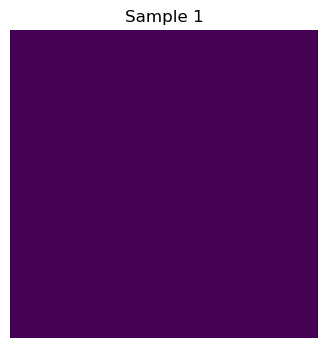

In [61]:
import matplotlib.pyplot as plt
image = model.sample(1, mode="argmax")


In [12]:
from random import randint
import numpy as np
import matplotlib.pyplot as plt
from gan_synthesis.preprocessing.transforms import read_cropped

def random_recon(model):
    num = randint(0, 368)
    image = read_cropped(idx=num, t="seg", as_type='pt').unsqueeze(0)
    seg_input = image.to(torch.float32).to("cuda")
    model.eval()
    with torch.no_grad():
        recon, mu, logvar = model(seg_input)
    
    recon = recon.argmax(dim=1)

    plt.imshow(image.squeeze().cpu().numpy())
    plt.show()
    plt.imshow(recon.squeeze().cpu().numpy())
    plt.show()
    

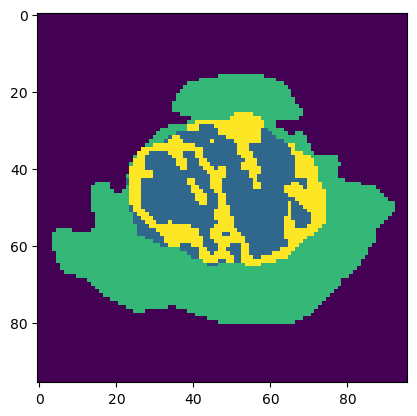

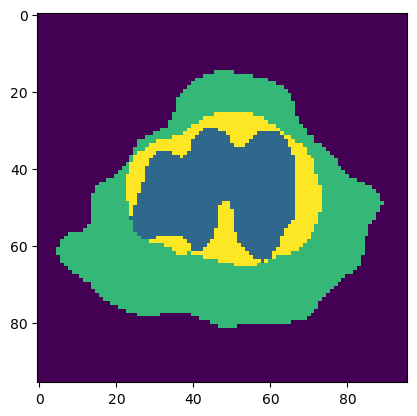

In [85]:
random_recon(model)

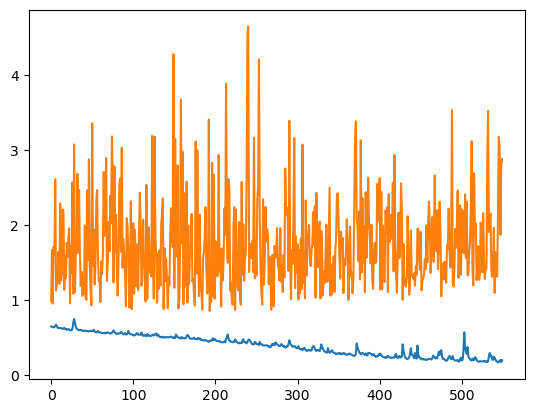

In [64]:
import matplotlib.pyplot as plt


plt.plot(ce_losses[50:])
plt.plot(val_losses[50:])
plt.show()

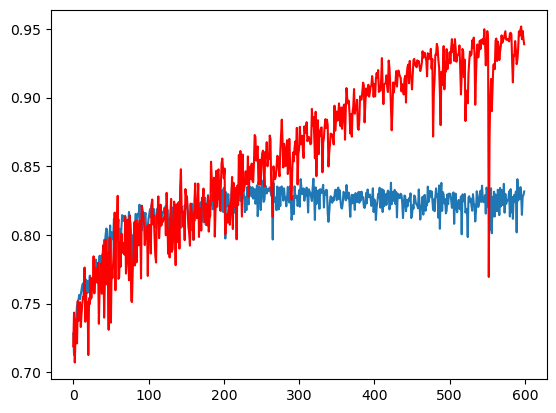

In [67]:
plt.plot(val_accuracies)
plt.plot(train_accuracies, 'r')
plt.show()